In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from tqdm import tqdm
from timeit import default_timer as timer
import itertools
import scipy.sparse as sp
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# https://www.dgl.ai/pages/start.html
import dgl
from dgl.nn import SAGEConv
from sklearn.metrics import roc_auc_score

# Featuring Engineering

**기본 지표 생성**

n = 일주일, 1개월, etc…

- 과거 n일 동안의 평균 종가, 표준 편차
- 과거 n일 동안의 평균 거래량, 표준 편차
- 전날 일일 수익률
- 과거 n일간 평균 수익률
- 과거 n일간 일일 수익률의 이동 평균

In [ ]:
# make basic indicators
def get_basic_indicators(df, week=5, month=21):
    df_copy = df.copy()
    price = df_copy['gts_iem_end_pr']
    volume = df_copy['gts_acl_trd_qty']
    avg_price_week = price.rolling(window=week).mean()
    avg_price_month = price.rolling(window=month).mean()
    std_price_week = price.rolling(window=week).std()
    std_price_month = price.rolling(window=month).std()

    avg_volume_week = volume.rolling(window=week).mean()
    avg_volume_month = volume.rolling(window=month).mean()
    std_volume_week = volume.rolling(window=week).std()
    std_volume_month = volume.rolling(window=month).std()

    return_1 = ((price - price.shift(1)) / price.shift(1)).shift(1).fillna(0)
    return_week = ((price - price.shift(week)) / price.shift(week)).shift(1).fillna(0)
    return_month = ((price - price.shift(month)) / price.shift(month)).shift(1).fillna(0)

    return_ma_week = return_1.rolling(window=week).mean()
    return_ma_month = return_1.rolling(window=month).mean()

    df_copy['avg_price_week'] = avg_price_week
    df_copy['avg_price_month'] = avg_price_month
    df_copy['std_price_week'] = std_price_week
    df_copy['std_price_month'] = std_price_month

    df_copy['avg_volume_week'] = avg_volume_week
    df_copy['avg_volume_month'] = avg_volume_month
    df_copy['std_volume_week'] = std_volume_week
    df_copy['std_volume_month'] = std_volume_month

    df_copy['return_1'] = return_1
    df_copy['return_week'] = return_week
    df_copy['return_month'] = return_month

    df_copy['return_ma_week'] = return_ma_week
    df_copy['return_ma_month'] = return_ma_month

    return df_copy

**기술 지표 생성**

- BOLL (볼린저 밴드)
    - 주가의 변동이 표준정규분포함수를 따른다는 가정 하에 주가 이동평균선의 위,아래에 생성되는 가상의 기준선
    - 상한선, 중심선, 하한선으로 보통 구분함
- MACD (이동평균 수렴확산지수)
    - MACD: 단기이동평균(12)와 장기이동평균선(26)의 차이값. 우리나라 주식시장에 맞게 5일, 20일로 대체하기도 함
    - MACD Signal: MACD의 9일 이동평균값
    - MACD Oscillator: MACD값과 Signal값의 차이
- RSI (상대강도지수)
    - 특정 기간 동안 주가의 상승/하락 각각의 변화량평균을 구하여 과매수 혹은 과매도 선호를 산출하는 지수
    - 30 이하면 과매도, 70 이상이면 과매수로 해석함
- Stochastic Oscillator (스토캐스틱 지표)
    - 최근 n일간의 최고가와 최저가를 기준으로 전자에 가까울수록 매도세, 후자에 가까울수록 매수세가 강함을 나타내는 지표
    - 20 이하면 과매도, 80 이상이면 과매수로 해석함

In [ ]:
# make techincal indicators
def get_boll(price,n=20):
  '''
  parameters:
    price: 가격 (종가, dtype=list)
    n: 종가 단순이동평균 계산 날짜수
  returns:
    볼린저밴드 하한선, 볼린저밴드 중심선, 볼린저밴드 상한선
  '''
  sma=price.rolling(window=n).mean()
  std=price.rolling(window=n).std()
  boll_mid=sma #볼린저밴드 중심선
  boll_high=sma+2*std #볼린저밴드 상한선
  boll_low=sma-2*std #볼린저밴드 하한선
  return boll_low, boll_mid, boll_high

def get_macd(price,n=9):
  '''
  parameters:
    price: 가격 (종가, dtype=list)
    n: 이동평균 계산 날짜수 (dtype=int)
  returns:
    MACD, MACD 시그널, MACD 오실레이터
  '''
  # 얘는 지수 이동 평균 Exponential Moving Average (EMA) 을 사용함
  ewm12=price.ewm(span=12, adjust=False).mean()
  ewm26=price.ewm(span=26, adjust=False).mean()
  macd=ewm12-ewm26 #MACD
  macd_signal=macd.ewm(span=n,min_periods=n-1,adjust=False).mean() #MACD Signal
  macd_oscil=macd-macd_signal #MACD Oscillator
  return macd, macd_signal, macd_oscil

def get_rsi(price,n1=14,n2=9):
  '''
  parameters:
    price: 가격 (종가, dtype=list)
    n1: 평균상승률/평균하락률 지수이동평균 계산 날짜수
    n2: 단순이동평균 계산 날짜수
  returns: RSI, RSI 시그널
  '''
  delta=price.diff()
  up=delta.clip(lower=0)
  down=delta.clip(upper=0)
  ema_up=up.ewm(com=n1, adjust=False).mean()
  ema_down=abs(down.ewm(com=n1, adjust=False).mean())
  rs=ema_up/ema_down
  rsi=100-np.floor((100/(1+rs))) #RSI
  rsi_signal=rsi.rolling(window=n2).mean() #RSI Signal
  return rsi, rsi_signal

def get_stochastic(high,low,close,n=15, m=5, t=3):
  '''
  parmameters:
    high: 고가 (dtype=list)
    low: 저가 (dtype=list)
    close: 종가 (dtype=list)
    n: fast K stochastic 도출 시 이동평균 구간
    m: slow K stochastic 도출 시 이동평균 구간
    t: slow D stochastic 도출 시 이동평균 구간
  returns:
    Fast%K, Slow%K, Slow%D
  '''
  min_low=low.rolling(n).min()
  max_high=high.rolling(n).max()
  fast_k=100*(close-min_low)/(max_high-min_low)
  slow_k=fast_k.rolling(m).mean()
  slow_d=slow_k.rolling(t).mean()
  return fast_k, slow_k, slow_d

In [ ]:
def get_technical_indicator(df):
    df_copy = df.copy()
    price = df['gts_iem_end_pr']
    high = df['gts_iem_hi_pr']
    low = df['gts_iem_low_pr']

    df_copy['BoLL_low'], df_copy['BoLL_mid'], df_copy['BoLL_high'] = get_boll(price)
    df_copy['MACD'], df_copy['MACD_signal'], df_copy['MACD_oscil'] = get_macd(price)
    df_copy['RSI'], df_copy['RSI_signal'] = get_rsi(price)
    df_copy['fast_K'], df_copy['slow_K'], df_copy['slow_D'] = get_stochastic(high, low, price)

    return df_copy

In [ ]:
def calculate_turbulence(data):
    """calculate turbulence index based on dow 30"""

    df = data.copy()
    df_price_pivot = df.pivot(index='trd_dt', columns='tck_iem_cd', values='gts_iem_end_pr')
    df_price_pivot = df_price_pivot.pct_change()

    unique_date = df.trd_dt.unique()
    # start after a month
    start = 21
    turbulence_index = [0] * start
    count = 0
    for i in tqdm(range(start, len(unique_date))):
        current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
        # use one month rolling window to calcualte covariance
        hist_price = df_price_pivot[
            (df_price_pivot.index < unique_date[i])
            & (df_price_pivot.index >= unique_date[i - start])
        ]
        # Drop tickers which has number missing values more than the "oldest" ticker
        filtered_hist_price = hist_price.iloc[hist_price.isna().sum().min():].dropna(axis=1)

        cov_temp = filtered_hist_price.cov()
        current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(filtered_hist_price, axis=0)

        temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(current_temp.values.T)
        if temp > 0:
            count += 1
            if count > 2:
                turbulence_temp = temp[0][0]
            else:
                # avoid large outlier because of the calculation just begins
                turbulence_temp = 0
        else:
            turbulence_temp = 0
        turbulence_index.append(turbulence_temp)
    turbulence_index = pd.DataFrame({'trd_dt': df_price_pivot.index, 'turbulence': turbulence_index})
    return turbulence_index

def add_turbulence(data):
    df = data.copy()
    turbulence_index = calculate_turbulence(df)
    df = df.merge(turbulence_index, on="trd_dt")
    df = df.sort_values(["trd_dt", "tck_iem_cd"]).reset_index(drop=True)
    return df

### 해외 국내 피쳐 생성

In [ ]:
# # turbulence index부터 생성
# df_with_tb = add_turbulence(df)

# # 종목 별로 데이터프레임 분할
# names = df_with_tb['tck_iem_cd'].unique()
# df_per_name = [df_with_tb[df_with_tb['tck_iem_cd'] == name] for name in names]

# # 종목 별로 기본지표 & 기술지표 생성
# df_per_name_final = []
# for df_i in df_per_name:
#     df_i = get_technical_indicator(df_i)
#     df_i = get_basic_indicators(df_i)
#     df_per_name_final.append(df_i)

# # concat all dataframes
# df_final = pd.concat(df_per_name_final)
# # reindex
# df_final = df_final.sort_values(['tck_iem_cd', 'trd_dt']).reset_index(drop=True)

# # save csv
# df_final.to_csv('NASDAQ_Stock_data.csv', encoding='cp949', index=False)

# Graph Building

## Method 1)
Correlation과 Cumulative return을 고려한 stock-specific metric을 통해 유사한 종목 계산

In [ ]:
# 데이터 PATH 조정
df_nas = pd.read_csv('NASDAQ_Stock_data_noqty.csv', encoding='cp949')
df_kor = pd.read_csv('KOREA_Stock_data_noqty.csv', encoding='cp949')

names_nas = df_nas['tck_iem_cd'].unique()
df_per_name_nas = [df_nas[df_nas['tck_iem_cd'] == name] for name in names_nas]

names_kor = df_kor['tck_iem_cd'].unique()
df_per_name_kor = [df_kor[df_kor['tck_iem_cd'] == name] for name in names_kor]

C:\Users\82109\AppData\Local\Temp\ipykernel_21944\236495483.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kor = pd.read_csv('KOREA_Stock_data_noqty.csv', encoding='cp949')


Target paper:

Dolphin, Rian, et al. "Measuring financial time series similarity with a view to identifying profitable stock market opportunities." International Conference on Case-Based Reasoning. Cham: Springer International Publishing, 2021.

https://arxiv.org/pdf/2107.03926.pdf

In [ ]:
def get_monthly_return(df):
    df_copy = df.copy()
    df_copy['trd_dt'] = df_copy['trd_dt'].astype(str)
    df_copy['date'] = pd.to_datetime(df_copy['trd_dt'])
    df_copy = df_copy.set_index('date')
    df_copy = df_copy.resample('M').last('D')
    df_copy['monthly_return'] = df_copy['gts_iem_end_pr'].pct_change()
    # df_copy = df_copy.fillna(0)
    df_copy = df_copy.dropna()
    return df_copy['monthly_return'].values

# from target paper
def pearson_correlation(x, y):
    return np.dot((x - np.mean(x)), (y - np.mean(y))) / ((np.linalg.norm(x - np.mean(x))) * (np.linalg.norm(y - np.mean(y))))

def adjusted_correlation(x, y):
    return np.dot(x, y) / ((np.linalg.norm(x)) * (np.linalg.norm(y)))

def calculate_cumulative_return(c_i, c_j):
    return np.abs((c_i+1).cumprod()[-1] - (c_j+1).cumprod()[-1])

def final_similarity(c_i, c_j, w=0.5):
    e = calculate_cumulative_return(c_i, c_j)
    tau = adjusted_correlation(c_i, c_j)
    return w / (1+e) + (1-w) * tau

In [ ]:
# 미국 종목 <-> 한국 종목간 유사도 비교 후 Similarity가 0.7 이상인 두 종목에 edge 연결
n, m = len(df_per_name_nas), len(df_per_name_kor)
threshold = 0.7
adjacency_matrix = sp.lil_matrix((n, m))

monthly_returns_nas = [get_monthly_return(i) for i in df_per_name_nas]
monthly_returns_kor = [get_monthly_return(i) for i in df_per_name_kor]

for i in tqdm(range(n)):
    for j in range(m):
        x = monthly_returns_nas[i]
        y = monthly_returns_kor[j]
        if len(x) != 7 or len(y) != 7:
            continue
        similarity = final_similarity(x, y)
        if similarity > threshold:
            adjacency_matrix[i, j] = similarity

adjacency_matrix = adjacency_matrix.tocsr()
sp.save_npz('Stock_Graph_Both.npz', adjacency_matrix)

100%|██████████| 2743/2743 [01:40<00:00, 27.28it/s]


In [ ]:
# Load our stock graph
adj = sp.load_npz('./Stock_Graph_Both.npz')

# 전체 엣지 개수
print('Total:',np.count_nonzero(adj.toarray()))
print(f'Ratio: {np.count_nonzero(adj.toarray()) / (n * m) * 100:.2f}%')

Total: 351901
Ratio: 5.24%


그래프 시각화 ( 타겟 노드 = 560 )

In [ ]:
target_node = 560
adj_np = adj.toarray()
similar_node = adj_np[target_node].argmax()

print('Target:',target_node)
print('Most similar stock:',similar_node)
print('Similarity:',adj[target_node, similar_node])

Target: 560
Most similar stock: 1071
Similarity: 0.9832331936173919


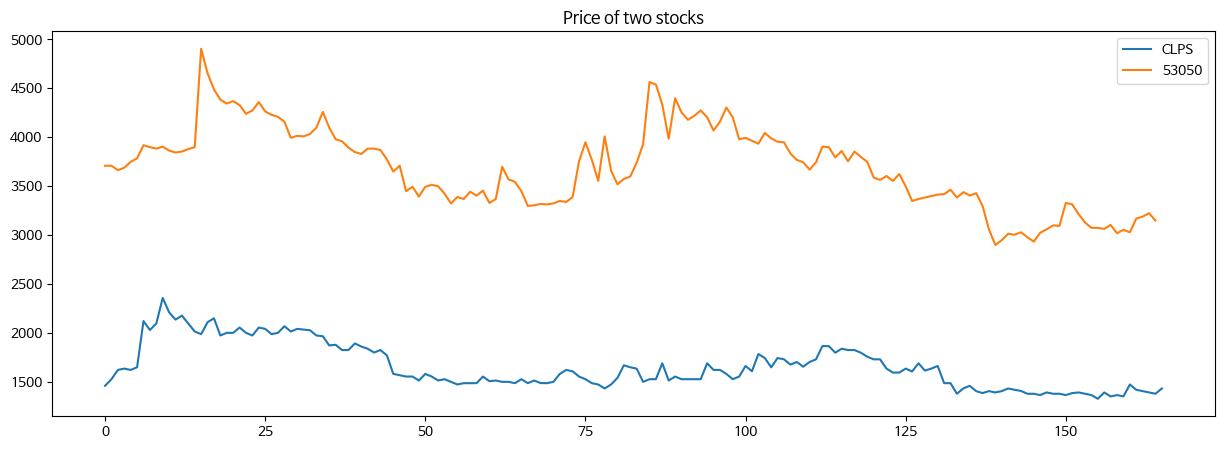

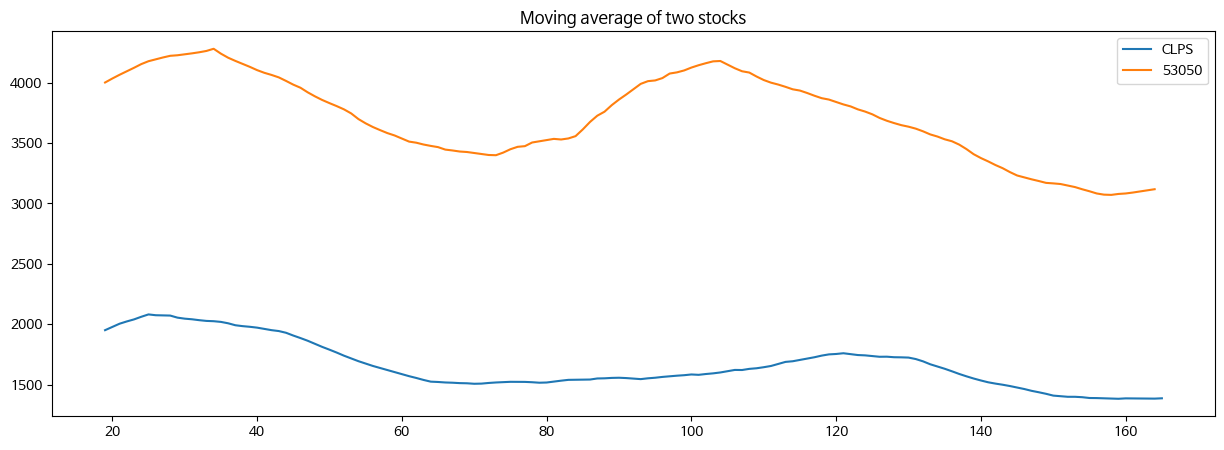

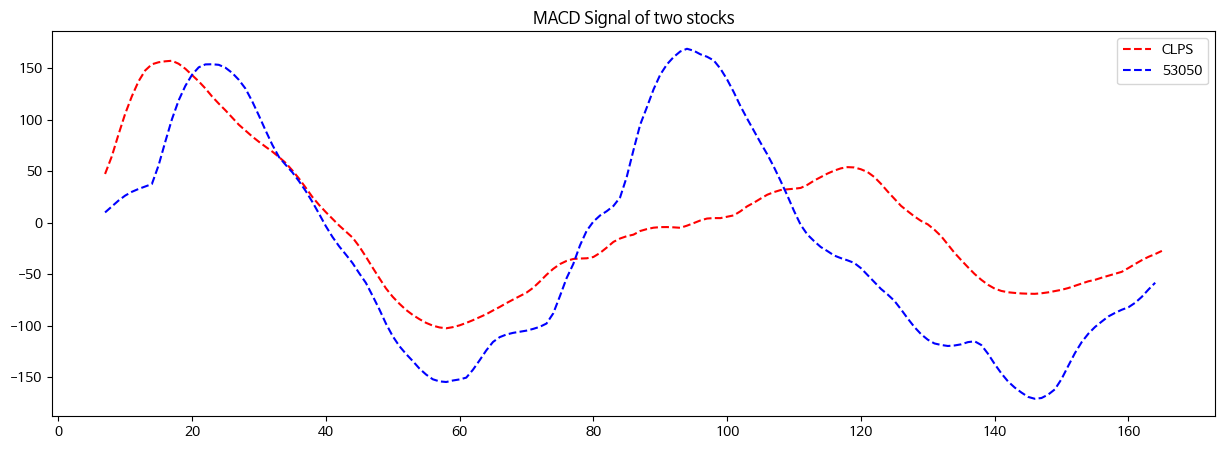

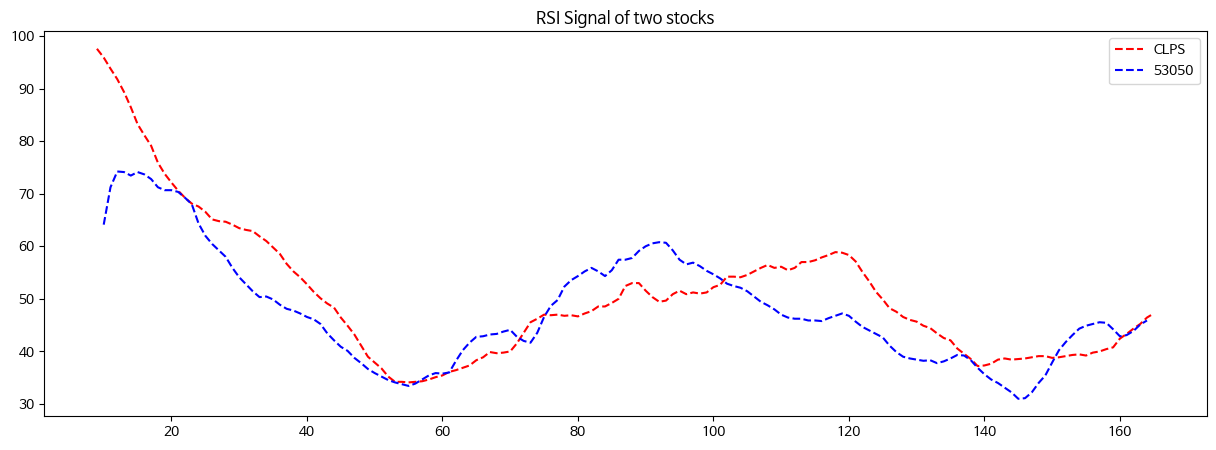

In [ ]:
def compare_two_stock(df1, df2):
    # '유사하다'고 판단한 한국주식과 미국주식을 시각화해서 비교
    def apply_exchange(df, exchange=1353.07):
        df_copy = df.copy()
        df_copy['gts_iem_end_pr'] = df_copy['gts_iem_end_pr'].values * exchange
        df_copy['gts_iem_hi_pr'] = df_copy['gts_iem_hi_pr'].values * exchange
        df_copy['gts_iem_low_pr'] = df_copy['gts_iem_low_pr'].values * exchange
        df_copy = get_technical_indicator(df_copy)
        return df_copy

    # 현재 환율에 맞추어 미국 주식의 달러->원으로 환산
    df1 = apply_exchange(df1)
    plt.figure(figsize=(15, 5))

    plt.plot(df1['gts_iem_end_pr'].values, label=df1['tck_iem_cd'].unique()[0])
    plt.plot(df2['gts_iem_end_pr'].values, label=df2['tck_iem_cd'].unique()[0])
    plt.title(f"Price of two stocks")
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(df1['BoLL_mid'].values, label=df1['tck_iem_cd'].unique()[0])
    plt.plot(df2['BoLL_mid'].values, label=df2['tck_iem_cd'].unique()[0])
    plt.title(f"Moving average of two stocks")
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(df1['MACD_signal'].values, label=df1['tck_iem_cd'].unique()[0], color='red', linestyle='--')
    plt.plot(df2['MACD_signal'].values, label=df2['tck_iem_cd'].unique()[0], color='blue', linestyle='--')
    plt.title(f"MACD Signal of two stocks")
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(df1['RSI_signal'].values, label=df1['tck_iem_cd'].unique()[0], color='red', linestyle='--')
    plt.plot(df2['RSI_signal'].values, label=df2['tck_iem_cd'].unique()[0], color='blue', linestyle='--')
    plt.title(f"RSI Signal of two stocks")
    plt.legend()
    plt.show()

compare_two_stock(df_per_name_nas[target_node], df_per_name_kor[similar_node])


결과 시각화

In [ ]:
# 코스피 & 코스닥 종목 정보 csv 파일 불러오기

df1 = pd.read_csv('./data_5155_20230916.csv', encoding='cp949')
df2 = pd.read_csv('./data_5206_20230916.csv', encoding='cp949')
kor_info = pd.concat([df1, df2])
kor_info = kor_info.reset_index(drop=True)
kor_info

,표준코드,단축코드,한글 종목명,한글 종목약명,영문 종목명,상장일,시장구분,증권구분,소속부,주식종류,액면가,상장주식수
0,KR7095570008,095570,AJ네트웍스보통주,AJ네트웍스,"AJ Networks Co.,Ltd.",2015/08/21,KOSPI,주권,NaN,보통주,1000,46822295
1,KR7006840003,006840,AK홀딩스보통주,AK홀딩스,"AK Holdings, Inc.",1999/08/11,KOSPI,주권,NaN,보통주,5000,13247561
2,KR7282330000,282330,BGF리테일보통주,BGF리테일,BGF Retail,2017/12/08,KOSPI,주권,NaN,보통주,1000,17283906
3,KR7027410000,027410,BGF보통주,BGF,BGF,2014/05/19,KOSPI,주권,NaN,보통주,1000,95716791
4,KR7138930003,138930,BNK금융지주보통주,BNK금융지주,BNK Financial Group Inc.,2011/03/30,KOSPI,주권,NaN,보통주,5000,322088438
...,...,...,...,...,...,...,...,...,...,...,...,...
2620,KR7024060006,024060,흥구석유,흥구석유,HeunguOil,1994/12/07,KOSDAQ,주권,중견기업부,보통주,100,15000000
2621,KR7010240000,010240,흥국,흥국,"HEUNGKUK METALTECH CO.,LTD.",2009/05/12,KOSDAQ,주권,우량기업부,보통주,500,12322696
2622,KR7189980006,189980,흥국에프엔비,흥국에프엔비,"HYUNGKUK F&B Co., Ltd",2015/08/07,KOSDAQ,주권,우량기업부,보통주,100,40137827
2623,KR7037440005,037440,희림종합건축사사무소,희림,Heerim Architects & Planners,2000/02/03,KOSDAQ,주권,우량기업부,보통주,500,13922475


In [ ]:
# 나스닥 종목 정보 csv 파일 불러오기
nas_info = pd.read_csv('./NAS_STK_IFO.csv', encoding='cp949')
nas_info

,isin_cd,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm
0,US00211V1061,AACG,ATA ...,ATA CreatGlo ...
1,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...
2,US02376R1023,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...
3,US03823U1025,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...
4,US0003602069,AAON,에이에이온 ...,AAON ...
...,...,...,...,...
2738,US4884452065,ZVRA,Zevra ...,Zevra ...
2739,US98987D1028,ZVSA,Zyversa ...,Zyversa ...
2740,US98985Y1082,ZYME,Zymeworks ...,Zymeworks ...
2741,US98986X1090,ZYNE,자이너바 파마수티컬스 ...,Zynerba Pharms ...


In [ ]:
# (티커코드 : 종목 이름) 딕셔너리 생성
nas_info['tck_iem_cd'] = nas_info['tck_iem_cd'].str.strip()
nas_dict = pd.Series(nas_info['fc_sec_eng_nm'].values,index=nas_info['tck_iem_cd']).to_dict()

# 티커코드 리스트 생성
nas_list = nas_info['tck_iem_cd'].unique().tolist()

# (단축코드 : 영문 종목약명) 딕셔너리 생성
kor_dict2 = pd.Series(kor_info['영문 종목명'].values,index=kor_info['단축코드']).to_dict()
# 단축코드 리스트 생성
kor_df = pd.read_csv('./KOREA_Stock_data_noqty.csv', low_memory=False)
tk_list = kor_df['tck_iem_cd'].unique()
tk_list.sort()

In [ ]:
# 한글 종목약명 리스트 생성
kor_list = [kor_dict2[t] for t in tk_list if t in kor_dict2]
kor_list

['HANWHA(3PB)',
 'CJ(4PC)',
 'AMOREG(3PC)',
 'Lotte Corporation(1P)',
 'MIRAE ASSET SECURITIES(2PB)',
 'KOREA CIRCUIT(2PB)',
 'DAEDUCK Co.,LTD(1P)',
 'SAMSUNG C&T CORPORATION(1PB)',
 'SK(1P)',
 'Haesung Industrial Co., Ltd.(1P)',
 'Lutronic(3PC)',
 'Inzisoft',
 'Vieworks Co., Ltd.',
 'DONGKUK STRUCTURES & CONSTRUCTION COMPANY LIMITED',
 'VISANG EDUCATION INC',
 'Chinyang Holdings Corporation',
 'Mercury Corporation',
 'SEOAM MACHINERY INDUSTRY CO., LTD.',
 'SEWOONMEDICAL CO., LTD.',
 'Mirae Asset Venture Investment Co., Ltd',
 'SNTEnergy Co.,Ltd.',
 'Sangsangin Industry Co., Ltd.',
 'WORLDEX INDUSTRY & TRADING CO., LTD',
 'WOORIM POWER TRAIN SOLUTION',
 'CQV Co., Ltd.',
 'MOBASE Co., Ltd.',
 'Eco&Dream',
 'IM CO., LTD',
 'N CITRON, INC.',
 'S&S TECH CORPORATION',
 'Haitai Confectionery and Foods Co., Ltd.',
 'Hydro Lithium',
 'HNK MACHINE TOOL CO.,LTD.',
 'Wemade Max',
 'Inhwa Precision Co., Ltd',
 'ABOV Semiconductor Co.,Ltd.',
 'DONGSUNG CHEMICAL Co., Ltd.',
 'K Auction Inc.',
 'REYO

Case of: 4980


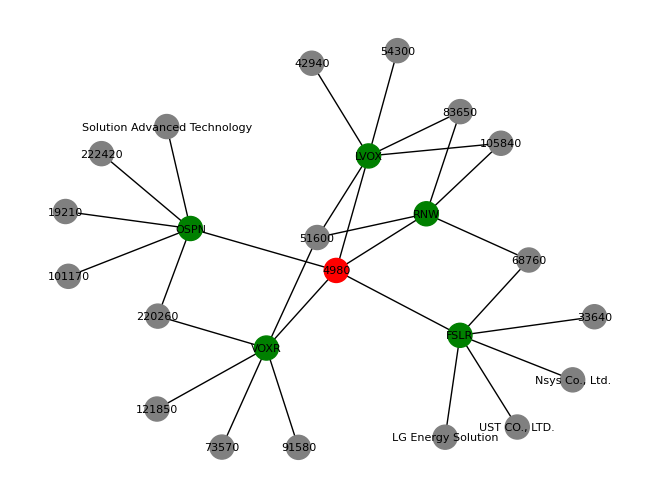

In [ ]:
def visualize_2_hop_graph(adj_np, names_nas, names_kor, name_dic_2, target_node=0, n=4):
    simple_G = nx.Graph()
    similar_idx = adj_np[:, target_node].argsort()[-n:]
    node_colors = {}
    node_colors[names_kor[target_node]] = 'red'
    for i in similar_idx:
        simple_G.add_edge(names_kor[target_node], names_nas[i])
        node_colors[names_nas[i]] = 'green'

        similar_idx_2hop = adj_np[i].argsort()[-n:]
        for j in similar_idx_2hop:
            simple_G.add_edge(names_nas[i], names_kor[j])
            if not node_colors.get(names_kor[j], False):
                node_colors[names_kor[j]] = 'gray'

    labels = {word:word for word in simple_G.nodes()}
    for k in labels.keys():
        if name_dic_2.get(k, False):
            labels[k] = name_dic_2[k]
    # pos = nx.spring_layout(simple_G)
    pos = nx.kamada_kawai_layout(simple_G)
    print('Case of:',names_kor[target_node])
    nx.draw(simple_G, pos, labels=labels, with_labels=True,node_color=[node_colors[node] for node in simple_G.nodes()], font_size=8)

visualize_2_hop_graph(adj_np, names_nas, names_kor, kor_dict2, target_node=315, n=5)

Case of: Mezzion Pharma Co., Ltd.


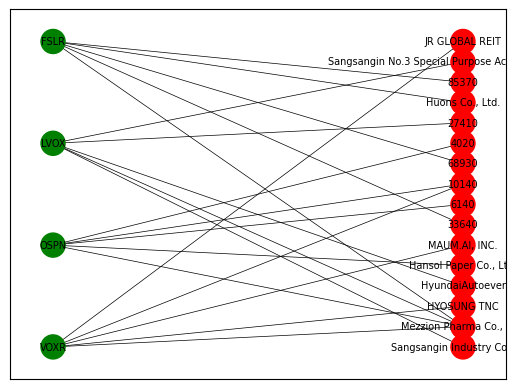

In [ ]:
# Bipartite 그래프 시각화

def visualize_bipartite_graph(adj_np, names_nas, names_kor, name_dic_2, target_node=0, n=4):
    simple_G = nx.Graph()
    similar_idx = adj_np[:, target_node].argsort()[-n:]
    node_colors = {}
    node_colors[names_kor[target_node]] = 'red'
    nas_nodes = []
    kor_nodes = [names_kor[target_node]]
    for i in similar_idx:
        simple_G.add_edge(names_kor[target_node], names_nas[i])
        nas_nodes.append(names_nas[i])
        node_colors[names_nas[i]] = 'green'

        similar_idx_2hop = adj_np[i].argsort()[-n:]
        for j in similar_idx_2hop:
            simple_G.add_edge(names_nas[i], names_kor[j])
            if not node_colors.get(names_kor[j], False):
                node_colors[names_kor[j]] = 'red'
                kor_nodes.append(names_kor[j])

    B = nx.Graph()
    B.add_nodes_from(nas_nodes, bipartite=0)
    B.add_nodes_from(kor_nodes, bipartite=1)
    B.add_edges_from(simple_G.edges())


    labels = {word:word for word in B.nodes()}
    for k in labels.keys():
        if name_dic_2.get(k, False):
            labels[k] = name_dic_2[k]

    print('Case of:', name_dic_2[names_kor[target_node]])
    nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, nas_nodes), labels=labels, with_labels=True, node_color=[node_colors[node] for node in B.nodes()], font_size=7, width = 0.5)
visualize_bipartite_graph(adj_np, nas_list, tk_list, kor_dict2, target_node=315, n=4)

## Method 2)
Compute Similarity through Stock embedding from Deep Neural Networks

Model Training & Feature Extraction

각 종목 별로 6일 단위의 sequence를 생성한 뒤 ['gts_iem_ong_pr', 'gts_iem_hi_pr', 'gts_iem_low_pr', 'gts_acl_trd_qty']을 사용해 종가('gts_iem_end_pr')를 예측하는 LSTM 모델을 학습시킨다. 학습된 LSTM 모델에 가장 마지막 즉, 최신의 sequence를 넣어 각 종목별 feature를 추출했으며, 이는 추후 node의 feature로 사용할 수 있도록 저장했다.


Framework Reference : Feng, Shibo, et al. "Relation-aware dynamic attributed graph attention network for stocks recommendation." Pattern Recognition 121 (2022): 108119.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

select = 'NASDAQ' # or 'KOREA'

if select == 'NASDAQ':
    df = pd.read_csv('./NASDAQ_Stock_data_noqty.csv', low_memory=False)

    os.makedirs('./nsdq_weight', exist_ok=True)
    os.makedirs('./nsdq_feature', exist_ok=True)

    weight_file = './nsdq_weight/{}_cp.pth'
    feature_file = './nsdq_feature/{}_feat.npy'


elif select == 'KOREA':
    df = pd.read_csv('./KOREA_Stock_data.csv', low_memory=False)

    os.makedirs('./kor_weight', exist_ok=True)
    os.makedirs('./kor_feature', exist_ok=True)

    weight_file = './kor_weight/{}_cp.pth'
    feature_file = './kor_feature/{}_feat.npy'

else:
    print('Wrong option.')
    exit()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 32, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.dropout(out)
        out = torch.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out

def prepare_data(data, sequence_length):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    return result

def main():
    tk_list = df['tck_iem_cd'].unique().tolist()
    sequence_length = 6

    for tk in tqdm(tk_list):
        test1 = df[df['tck_iem_cd'] == tk]
        cols = ['gts_iem_ong_pr', 'gts_iem_hi_pr', 'gts_iem_low_pr', 'gts_acl_trd_qty', 'gts_iem_end_pr']
        test1 = df[cols]

        data = test1.to_numpy()
        result = prepare_data(data, sequence_length)


        # Creating training data
        row = round(0.8 * result.shape[0])
        train = result
        x_train = train[:, :-1]
        y_train = train[:, -1][:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1][:, -1]


        num_features = len(test1.columns)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_features))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_features))


        x_train = torch.from_numpy(x_train).float().to(device)
        y_train = torch.from_numpy(y_train).float().unsqueeze(1).to(device)
        x_test = torch.from_numpy(x_test).float().to(device)
        y_test = torch.from_numpy(y_test).float().unsqueeze(1).to(device)

        model = LSTMModel(num_features, 5, 1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()


        start = timer()
        num_epochs = 3
        batch_size = 128
        for epoch in range(num_epochs):
            for i in range(0, len(x_train), batch_size):
                inputs = x_train[i:i + batch_size]
                labels = y_train[i:i + batch_size]

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

        torch.save(model.state_dict(), weight_file.format(tk))
        print(f'{tk} done.')
        end = timer()
        print(end - start)

if __name__ == "__main__":
    main()

  0%|          | 0/2743 [00:00<?, ?it/s]

Epoch [1/3], Loss: 397.3226
Epoch [2/3], Loss: 380.3647


  0%|          | 1/2743 [00:20<15:44:30, 20.67s/it]

Epoch [3/3], Loss: 405.3923
AACG done.
20.313313200000266
Epoch [1/3], Loss: 410.8319
Epoch [2/3], Loss: 426.9342


  0%|          | 2/2743 [00:41<15:48:30, 20.76s/it]

Epoch [3/3], Loss: 381.3617
AADI done.
20.47835259999556
Epoch [1/3], Loss: 396.7847
Epoch [2/3], Loss: 434.7950


  0%|          | 3/2743 [01:02<15:48:28, 20.77s/it]

Epoch [3/3], Loss: 411.9907
AAL done.
20.434442599995236
Epoch [1/3], Loss: 406.6659
Epoch [2/3], Loss: 389.2774


  0%|          | 4/2743 [01:23<15:59:06, 21.01s/it]

Epoch [3/3], Loss: 403.6235
AAOI done.
21.037649999998393
Epoch [1/3], Loss: 385.4862
Epoch [2/3], Loss: 400.9230


  0%|          | 5/2743 [01:45<16:04:28, 21.14s/it]

Epoch [3/3], Loss: 432.2950
AAON done.
21.002962300000945
Epoch [1/3], Loss: 379.6880
Epoch [2/3], Loss: 424.9857


  0%|          | 6/2743 [02:05<15:58:08, 21.00s/it]

Epoch [3/3], Loss: 408.6058
AAPL done.
20.410152699994796
Epoch [1/3], Loss: 406.6572
Epoch [2/3], Loss: 381.3290


  0%|          | 7/2743 [02:26<15:57:58, 21.01s/it]

Epoch [3/3], Loss: 432.8084
ABCB done.
20.675970399999642
Epoch [1/3], Loss: 398.8903
Epoch [2/3], Loss: 423.8319


  0%|          | 8/2743 [02:47<16:00:40, 21.08s/it]

Epoch [3/3], Loss: 390.2593
ABCL done.
20.87225629999739
Epoch [1/3], Loss: 399.3224
Epoch [2/3], Loss: 392.8149


  0%|          | 9/2743 [03:08<15:58:07, 21.03s/it]

Epoch [3/3], Loss: 389.0816
ABCM done.
20.569724699998915
Epoch [1/3], Loss: 425.9759
Epoch [2/3], Loss: 358.1812


  0%|          | 10/2743 [03:30<16:00:42, 21.09s/it]

Epoch [3/3], Loss: 400.0216
ABEO done.
20.88941039999918
Epoch [1/3], Loss: 399.0878
Epoch [2/3], Loss: 328.1319


  0%|          | 11/2743 [03:52<16:16:45, 21.45s/it]

Epoch [3/3], Loss: 406.0105
ABIO done.
21.90214389999892
Epoch [1/3], Loss: 376.9716
Epoch [2/3], Loss: 427.0291


  0%|          | 12/2743 [04:14<16:25:18, 21.65s/it]

Epoch [3/3], Loss: 433.4691
ABNB done.
21.73324899999716
Epoch [1/3], Loss: 385.1601
Epoch [2/3], Loss: 418.3763


  0%|          | 13/2743 [04:37<16:38:48, 21.95s/it]

Epoch [3/3], Loss: 378.8740
ABOS done.
22.263132799998857
Epoch [1/3], Loss: 359.2986
Epoch [2/3], Loss: 392.1166


  1%|          | 14/2743 [04:59<16:44:22, 22.08s/it]

Epoch [3/3], Loss: 381.5589
ABSI done.
22.008474999995087
Epoch [1/3], Loss: 399.0794
Epoch [2/3], Loss: 388.5246


  1%|          | 15/2743 [05:22<16:53:54, 22.30s/it]

Epoch [3/3], Loss: 406.8647
ABUS done.
22.43091419999837
Epoch [1/3], Loss: 426.8619
Epoch [2/3], Loss: 415.8811


  1%|          | 16/2743 [05:45<17:01:11, 22.47s/it]

Epoch [3/3], Loss: 396.2118
ABVC done.
22.47223909999593
Epoch [1/3], Loss: 388.2930
Epoch [2/3], Loss: 390.7448


  1%|          | 17/2743 [06:07<16:54:25, 22.33s/it]

Epoch [3/3], Loss: 392.1670
ACAD done.
21.62211770000431
Epoch [1/3], Loss: 391.7139
Epoch [2/3], Loss: 413.6146


  1%|          | 18/2743 [06:28<16:42:42, 22.08s/it]

Epoch [3/3], Loss: 420.4555
ACB done.
21.143030799998087
Epoch [1/3], Loss: 433.4847
Epoch [2/3], Loss: 421.9537


  1%|          | 19/2743 [06:49<16:29:56, 21.81s/it]

Epoch [3/3], Loss: 411.2859
ACCD done.
20.79876819999481
Epoch [1/3], Loss: 380.2556
Epoch [2/3], Loss: 410.4369


  1%|          | 20/2743 [07:10<16:18:15, 21.56s/it]

Epoch [3/3], Loss: 408.4187
ACDC done.
20.621519499996793
Epoch [1/3], Loss: 416.7729
Epoch [2/3], Loss: 388.5356


  1%|          | 21/2743 [07:32<16:14:33, 21.48s/it]

Epoch [3/3], Loss: 434.8406
ACER done.
20.965448499999184
Epoch [1/3], Loss: 408.0592
Epoch [2/3], Loss: 408.2500


  1%|          | 22/2743 [07:53<16:07:00, 21.32s/it]

Epoch [3/3], Loss: 391.8391
ACET done.
20.61059419999947
Epoch [1/3], Loss: 415.6535
Epoch [2/3], Loss: 363.9662


  1%|          | 23/2743 [08:13<16:00:34, 21.19s/it]

Epoch [3/3], Loss: 396.3075
ACGL done.
20.524654400003783
Epoch [1/3], Loss: 392.2249
Epoch [2/3], Loss: 428.2220


  1%|          | 24/2743 [08:35<15:57:46, 21.14s/it]

Epoch [3/3], Loss: 396.3304
ACGLN done.
20.66673830000218
Epoch [1/3], Loss: 410.7048
Epoch [2/3], Loss: 405.2066


  1%|          | 25/2743 [08:55<15:54:00, 21.06s/it]

Epoch [3/3], Loss: 398.3981
ACGLO done.
20.533310499995423
Epoch [1/3], Loss: 384.6334
Epoch [2/3], Loss: 415.4189


  1%|          | 26/2743 [09:17<15:54:52, 21.09s/it]

Epoch [3/3], Loss: 409.8227
ACHC done.
20.801565000001574
Epoch [1/3], Loss: 396.8655
Epoch [2/3], Loss: 394.3983


  1%|          | 27/2743 [09:38<15:53:06, 21.06s/it]

Epoch [3/3], Loss: 384.3252
ACHL done.
20.638895299998694
Epoch [1/3], Loss: 418.5295
Epoch [2/3], Loss: 401.8531


  1%|          | 28/2743 [09:58<15:50:46, 21.01s/it]

Epoch [3/3], Loss: 418.5805
ACHV done.
20.566806299997552
Epoch [1/3], Loss: 377.5578
Epoch [2/3], Loss: 378.5131


  1%|          | 29/2743 [10:19<15:47:19, 20.94s/it]

Epoch [3/3], Loss: 330.3974
ACIU done.
20.44047760000103
Epoch [1/3], Loss: 421.6850
Epoch [2/3], Loss: 402.6453


  1%|          | 30/2743 [10:40<15:44:23, 20.89s/it]

Epoch [3/3], Loss: 398.4319
ACIW done.
20.40927019999799
Epoch [1/3], Loss: 397.0546
Epoch [2/3], Loss: 386.9471


  1%|          | 31/2743 [11:01<15:42:38, 20.86s/it]

Epoch [3/3], Loss: 379.3089
ACLS done.
20.44238580000092
Epoch [1/3], Loss: 408.1316
Epoch [2/3], Loss: 419.3422


  1%|          | 32/2743 [11:22<15:41:12, 20.83s/it]

Epoch [3/3], Loss: 413.0493
ACLX done.
20.434464499994647
Epoch [1/3], Loss: 397.3842
Epoch [2/3], Loss: 400.6945


  1%|          | 33/2743 [11:43<15:42:53, 20.88s/it]

Epoch [3/3], Loss: 400.7312
ACMR done.
20.63872270000138
Epoch [1/3], Loss: 422.9944
Epoch [2/3], Loss: 413.2834


  1%|          | 34/2743 [12:03<15:43:47, 20.90s/it]

Epoch [3/3], Loss: 409.5923
ACNB done.
20.624131599994143
Epoch [1/3], Loss: 406.9316
Epoch [2/3], Loss: 398.7935


  1%|▏         | 35/2743 [12:25<15:50:54, 21.07s/it]

Epoch [3/3], Loss: 394.5417
ACON done.
21.10682340000494
Epoch [1/3], Loss: 421.4467
Epoch [2/3], Loss: 388.0352


  1%|▏         | 36/2743 [12:46<15:49:53, 21.05s/it]

Epoch [3/3], Loss: 416.0756
ACOR done.
20.664886999999
Epoch [1/3], Loss: 401.0701
Epoch [2/3], Loss: 389.8251


  1%|▏         | 37/2743 [13:07<15:47:12, 21.00s/it]

Epoch [3/3], Loss: 407.5680
ACRS done.
20.53579410000384
Epoch [1/3], Loss: 397.6111
Epoch [2/3], Loss: 393.9779


  1%|▏         | 38/2743 [13:28<15:45:03, 20.96s/it]

Epoch [3/3], Loss: 387.5128
ACRV done.
20.509191499993904
Epoch [1/3], Loss: 418.3348
Epoch [2/3], Loss: 372.3665


  1%|▏         | 39/2743 [13:48<15:42:17, 20.91s/it]

Epoch [3/3], Loss: 409.5961
ACRX done.
20.43641100000241
Epoch [1/3], Loss: 432.1046
Epoch [2/3], Loss: 408.9674


  1%|▏         | 40/2743 [14:10<15:43:50, 20.95s/it]

Epoch [3/3], Loss: 384.9774
ACST done.
20.704474300000584
Epoch [1/3], Loss: 421.9498
Epoch [2/3], Loss: 414.8738


  1%|▏         | 41/2743 [14:30<15:43:35, 20.95s/it]

Epoch [3/3], Loss: 353.3087
ACT done.
20.61205119999795
Epoch [1/3], Loss: 383.5070
Epoch [2/3], Loss: 425.1304


  2%|▏         | 42/2743 [14:51<15:42:02, 20.93s/it]

Epoch [3/3], Loss: 384.5963
ACTG done.
20.505851200003235
Epoch [1/3], Loss: 416.8079
Epoch [2/3], Loss: 400.4371


  2%|▏         | 43/2743 [15:12<15:43:38, 20.97s/it]

Epoch [3/3], Loss: 414.8216
ACVA done.
20.72455259999697
Epoch [1/3], Loss: 379.5966
Epoch [2/3], Loss: 399.6427


  2%|▏         | 44/2743 [15:33<15:41:57, 20.94s/it]

Epoch [3/3], Loss: 404.7960
ACXP done.
20.525410499998543
Epoch [1/3], Loss: 410.8626
Epoch [2/3], Loss: 378.9796


  2%|▏         | 45/2743 [15:54<15:44:17, 21.00s/it]

Epoch [3/3], Loss: 432.5945
ADAP done.
20.792096799996216
Epoch [1/3], Loss: 362.3888
Epoch [2/3], Loss: 408.6901


  2%|▏         | 46/2743 [16:16<15:48:26, 21.10s/it]

Epoch [3/3], Loss: 396.1585
ADBE done.
20.98905840000225
Epoch [1/3], Loss: 403.8122
Epoch [2/3], Loss: 408.3640


  2%|▏         | 47/2743 [16:37<15:50:11, 21.15s/it]

Epoch [3/3], Loss: 407.7847
ADD done.
20.910612200001196
Epoch [1/3], Loss: 394.7275
Epoch [2/3], Loss: 391.6699


  2%|▏         | 48/2743 [16:58<15:51:05, 21.17s/it]

Epoch [3/3], Loss: 397.7550
ADEA done.
20.893197500001406
Epoch [1/3], Loss: 415.1764
Epoch [2/3], Loss: 384.3029


  2%|▏         | 49/2743 [17:20<15:51:40, 21.20s/it]

Epoch [3/3], Loss: 435.9600
ADES done.
20.883085100002063
Epoch [1/3], Loss: 383.6909
Epoch [2/3], Loss: 320.8503


  2%|▏         | 50/2743 [17:41<15:50:26, 21.18s/it]

Epoch [3/3], Loss: 415.4116
ADI done.
20.78927239999757
Epoch [1/3], Loss: 399.5733
Epoch [2/3], Loss: 394.3632


  2%|▏         | 51/2743 [18:02<15:50:26, 21.18s/it]

Epoch [3/3], Loss: 382.9430
ADIL done.
20.85768359999929
Epoch [1/3], Loss: 397.7379
Epoch [2/3], Loss: 408.5439


  2%|▏         | 52/2743 [18:23<15:46:04, 21.09s/it]

Epoch [3/3], Loss: 420.1207
ADMA done.
20.53483899999992
Epoch [1/3], Loss: 425.9916
Epoch [2/3], Loss: 394.7971


  2%|▏         | 53/2743 [18:44<15:42:32, 21.02s/it]

Epoch [3/3], Loss: 386.3776
ADMP done.
20.51271270000143
Epoch [1/3], Loss: 376.8504
Epoch [2/3], Loss: 391.3356


  2%|▏         | 54/2743 [19:04<15:36:24, 20.89s/it]

Epoch [3/3], Loss: 412.0815
ADN done.
20.24558590000379
Epoch [1/3], Loss: 411.0632
Epoch [2/3], Loss: 427.9394


  2%|▏         | 55/2743 [19:25<15:34:13, 20.85s/it]

Epoch [3/3], Loss: 416.5345
ADP done.
20.41481290000229
Epoch [1/3], Loss: 383.8975
Epoch [2/3], Loss: 403.9056


  2%|▏         | 56/2743 [19:46<15:33:02, 20.83s/it]

Epoch [3/3], Loss: 378.0417
ADPT done.
20.447588399998494
Epoch [1/3], Loss: 409.3706
Epoch [2/3], Loss: 360.5117


  2%|▏         | 57/2743 [20:07<15:33:54, 20.86s/it]

Epoch [3/3], Loss: 425.2831
ADSE done.
20.581093699998746
Epoch [1/3], Loss: 384.0391
Epoch [2/3], Loss: 398.6801


  2%|▏         | 58/2743 [20:27<15:31:37, 20.82s/it]

Epoch [3/3], Loss: 415.2794
ADSK done.
20.374274900001183
Epoch [1/3], Loss: 409.7729
Epoch [2/3], Loss: 418.4142


  2%|▏         | 59/2743 [20:48<15:34:17, 20.89s/it]

Epoch [3/3], Loss: 418.5893
ADTH done.
20.688088299997617
Epoch [1/3], Loss: 391.4254
Epoch [2/3], Loss: 409.8303


  2%|▏         | 60/2743 [21:09<15:33:57, 20.89s/it]

Epoch [3/3], Loss: 381.3315
ADTN done.
20.542415900003107
Epoch [1/3], Loss: 414.3767
Epoch [2/3], Loss: 399.8285


  2%|▏         | 61/2743 [21:30<15:37:12, 20.97s/it]

Epoch [3/3], Loss: 372.8932
ADTX done.
20.81038350000017
Epoch [1/3], Loss: 387.3399
Epoch [2/3], Loss: 386.0670


  2%|▏         | 62/2743 [21:51<15:34:20, 20.91s/it]

Epoch [3/3], Loss: 406.3655
ADUS done.
20.431258999997226
Epoch [1/3], Loss: 402.2835
Epoch [2/3], Loss: 392.6873


  2%|▏         | 63/2743 [22:12<15:32:59, 20.89s/it]

Epoch [3/3], Loss: 398.9139
ADV done.
20.492394700006116
Epoch [1/3], Loss: 415.8459
Epoch [2/3], Loss: 392.1025


  2%|▏         | 64/2743 [22:33<15:29:56, 20.83s/it]

Epoch [3/3], Loss: 396.1855
ADVM done.
20.343163400000776
Epoch [1/3], Loss: 408.5224
Epoch [2/3], Loss: 403.0565


  2%|▏         | 65/2743 [22:54<15:30:52, 20.86s/it]

Epoch [3/3], Loss: 375.2301
ADXN done.
20.582212899993465
Epoch [1/3], Loss: 350.1022
Epoch [2/3], Loss: 409.9418


  2%|▏         | 66/2743 [23:15<15:35:31, 20.97s/it]

Epoch [3/3], Loss: 390.8162
AEHL done.
20.878414099999645
Epoch [1/3], Loss: 391.9358
Epoch [2/3], Loss: 389.0162


  2%|▏         | 67/2743 [23:36<15:34:20, 20.95s/it]

Epoch [3/3], Loss: 403.0435
AEHR done.
20.550486300002376
Epoch [1/3], Loss: 384.3176
Epoch [2/3], Loss: 402.6533


  2%|▏         | 68/2743 [23:57<15:40:42, 21.10s/it]

Epoch [3/3], Loss: 400.9751
AEI done.
21.10168379999959
Epoch [1/3], Loss: 416.3234
Epoch [2/3], Loss: 408.4818


  3%|▎         | 69/2743 [24:18<15:39:58, 21.09s/it]

Epoch [3/3], Loss: 400.2064
AEIS done.
20.722374200006016
Epoch [1/3], Loss: 390.3470
Epoch [2/3], Loss: 414.0239


  3%|▎         | 70/2743 [24:39<15:37:40, 21.05s/it]

Epoch [3/3], Loss: 424.6230
AEMD done.
20.598487999995996
Epoch [1/3], Loss: 416.7077
Epoch [2/3], Loss: 403.5094


  3%|▎         | 71/2743 [25:00<15:33:00, 20.95s/it]

Epoch [3/3], Loss: 421.4093
AEP done.
20.384594499999366
Epoch [1/3], Loss: 326.6979
Epoch [2/3], Loss: 394.7818


  3%|▎         | 72/2743 [25:21<15:27:46, 20.84s/it]

Epoch [3/3], Loss: 382.0790
AEY done.
20.2455415000004
Epoch [1/3], Loss: 394.0400
Epoch [2/3], Loss: 419.0307


  3%|▎         | 73/2743 [25:42<15:28:31, 20.87s/it]

Epoch [3/3], Loss: 386.8530
AEYE done.
20.583841800005757
Epoch [1/3], Loss: 439.9456
Epoch [2/3], Loss: 401.4913


  3%|▎         | 74/2743 [26:02<15:27:27, 20.85s/it]

Epoch [3/3], Loss: 395.7694
AEZS done.
20.463559099996928
Epoch [1/3], Loss: 396.6539
Epoch [2/3], Loss: 394.5827


  3%|▎         | 75/2743 [26:23<15:23:41, 20.77s/it]

Epoch [3/3], Loss: 394.8799
AFCG done.
20.252950399997644
Epoch [1/3], Loss: 382.9631
Epoch [2/3], Loss: 434.6245


  3%|▎         | 76/2743 [26:44<15:22:17, 20.75s/it]

Epoch [3/3], Loss: 438.8872
AFIB done.
20.359134999998787
Epoch [1/3], Loss: 389.6125
Epoch [2/3], Loss: 385.8650


  3%|▎         | 77/2743 [27:05<15:25:35, 20.83s/it]

Epoch [3/3], Loss: 391.2199
AFMD done.
20.68436450000445
Epoch [1/3], Loss: 385.6913
Epoch [2/3], Loss: 398.8796


  3%|▎         | 78/2743 [27:25<15:25:04, 20.83s/it]

Epoch [3/3], Loss: 428.7632
AFRM done.
20.4788131000023
Epoch [1/3], Loss: 419.4927
Epoch [2/3], Loss: 405.7681


  3%|▎         | 79/2743 [27:47<15:29:01, 20.92s/it]

Epoch [3/3], Loss: 428.4005
AFYA done.
20.809629000003042
Epoch [1/3], Loss: 384.6013
Epoch [2/3], Loss: 425.5612


  3%|▎         | 80/2743 [28:07<15:28:13, 20.91s/it]

Epoch [3/3], Loss: 419.8672
AGAE done.
20.552733100004843
Epoch [1/3], Loss: 394.8286
Epoch [2/3], Loss: 407.3193


  3%|▎         | 81/2743 [28:28<15:28:03, 20.92s/it]

Epoch [3/3], Loss: 386.4770
AGBA done.
20.592731400000048
Epoch [1/3], Loss: 400.5455
Epoch [2/3], Loss: 423.7812


  3%|▎         | 82/2743 [28:49<15:28:31, 20.94s/it]

Epoch [3/3], Loss: 373.0985
AGEN done.
20.644028399998206
Epoch [1/3], Loss: 362.0834
Epoch [2/3], Loss: 393.5523


  3%|▎         | 83/2743 [29:11<15:32:14, 21.03s/it]

Epoch [3/3], Loss: 432.2627
AGFY done.
20.903278099998715
Epoch [1/3], Loss: 400.9779
Epoch [2/3], Loss: 368.3882


  3%|▎         | 84/2743 [29:32<15:31:36, 21.02s/it]

Epoch [3/3], Loss: 414.0855
AGIL done.
20.662850799999433
Epoch [1/3], Loss: 404.4882
Epoch [2/3], Loss: 410.4789


  3%|▎         | 85/2743 [29:52<15:27:34, 20.94s/it]

Epoch [3/3], Loss: 386.7361
AGIO done.
20.405049799999688
Epoch [1/3], Loss: 403.1956
Epoch [2/3], Loss: 418.2673


  3%|▎         | 86/2743 [30:13<15:23:58, 20.86s/it]

Epoch [3/3], Loss: 411.0837
AGLE done.
20.341328199996497
Epoch [1/3], Loss: 440.9482
Epoch [2/3], Loss: 408.6393


  3%|▎         | 87/2743 [30:34<15:21:44, 20.82s/it]

Epoch [3/3], Loss: 389.1976
AGNC done.
20.38287080000009
Epoch [1/3], Loss: 394.5750
Epoch [2/3], Loss: 413.4381


  3%|▎         | 88/2743 [30:55<15:21:44, 20.83s/it]

Epoch [3/3], Loss: 420.2471
AGNCL done.
20.50434849999874
Epoch [1/3], Loss: 410.2808
Epoch [2/3], Loss: 424.4032


  3%|▎         | 89/2743 [31:16<15:27:16, 20.96s/it]

Epoch [3/3], Loss: 400.8631
AGNCM done.
20.925569999999425
Epoch [1/3], Loss: 399.4901
Epoch [2/3], Loss: 382.9314


  3%|▎         | 90/2743 [31:37<15:27:12, 20.97s/it]

Epoch [3/3], Loss: 353.1558
AGNCN done.
20.64492009999958
Epoch [1/3], Loss: 403.7061
Epoch [2/3], Loss: 430.5177


  3%|▎         | 91/2743 [31:58<15:22:55, 20.88s/it]

Epoch [3/3], Loss: 404.7890
AGNCO done.
20.32530350000161
Epoch [1/3], Loss: 397.9246
Epoch [2/3], Loss: 385.1785


  3%|▎         | 92/2743 [32:19<15:24:36, 20.93s/it]

Epoch [3/3], Loss: 426.7868
AGNCP done.
20.695611099996313
Epoch [1/3], Loss: 437.8446
Epoch [2/3], Loss: 410.0755


  3%|▎         | 93/2743 [32:39<15:19:32, 20.82s/it]

Epoch [3/3], Loss: 381.0332
AGRI done.
20.230218100005004
Epoch [1/3], Loss: 376.3566
Epoch [2/3], Loss: 403.4147


  3%|▎         | 94/2743 [33:00<15:16:35, 20.76s/it]

Epoch [3/3], Loss: 392.4570
AGRX done.
20.28268240000034
Epoch [1/3], Loss: 419.4350
Epoch [2/3], Loss: 392.5671


  3%|▎         | 95/2743 [33:21<15:17:52, 20.80s/it]

Epoch [3/3], Loss: 377.7031
AGYS done.
20.53828020000219
Epoch [1/3], Loss: 386.6187
Epoch [2/3], Loss: 379.0086


  3%|▎         | 96/2743 [33:42<15:22:17, 20.91s/it]

Epoch [3/3], Loss: 408.8865
AHCO done.
20.81555500000104
Epoch [1/3], Loss: 383.9249
Epoch [2/3], Loss: 389.9753


  4%|▎         | 97/2743 [34:03<15:23:28, 20.94s/it]

Epoch [3/3], Loss: 402.5239
AHG done.
20.68178949999856
Epoch [1/3], Loss: 422.4107
Epoch [2/3], Loss: 416.2200


  4%|▎         | 98/2743 [34:24<15:20:04, 20.87s/it]

Epoch [3/3], Loss: 392.4648
AIHS done.
20.368667800001276
Epoch [1/3], Loss: 432.4309
Epoch [2/3], Loss: 410.2959


  4%|▎         | 99/2743 [34:45<15:23:57, 20.97s/it]

Epoch [3/3], Loss: 417.9845
AIMD done.
20.849519799994596
Epoch [1/3], Loss: 377.4632
Epoch [2/3], Loss: 403.8105


  4%|▎         | 100/2743 [35:06<15:25:27, 21.01s/it]

Epoch [3/3], Loss: 448.6398
AIP done.
20.774371900006372
Epoch [1/3], Loss: 411.9623
Epoch [2/3], Loss: 410.8078


  4%|▎         | 101/2743 [35:27<15:25:07, 21.01s/it]

Epoch [3/3], Loss: 414.5256
AIRG done.
20.67850460000045
Epoch [1/3], Loss: 398.4511
Epoch [2/3], Loss: 390.3940


  4%|▎         | 102/2743 [35:48<15:25:37, 21.03s/it]

Epoch [3/3], Loss: 466.0761
AIRS done.
20.740037000003213
Epoch [1/3], Loss: 408.7330
Epoch [2/3], Loss: 401.9620


  4%|▍         | 103/2743 [36:08<15:17:46, 20.86s/it]

Epoch [3/3], Loss: 387.8918
AKAM done.
20.1287353000007
Epoch [1/3], Loss: 411.1304
Epoch [2/3], Loss: 413.2298


  4%|▍         | 104/2743 [36:29<15:12:48, 20.75s/it]

Epoch [3/3], Loss: 402.9538
AKAN done.
20.17729180000606
Epoch [1/3], Loss: 440.0017
Epoch [2/3], Loss: 374.9796


  4%|▍         | 105/2743 [36:50<15:11:05, 20.72s/it]

Epoch [3/3], Loss: 393.5940
AKBA done.
20.316003500003717
Epoch [1/3], Loss: 414.3873
Epoch [2/3], Loss: 418.2393


  4%|▍         | 106/2743 [37:10<15:12:21, 20.76s/it]

Epoch [3/3], Loss: 426.7228
AKLI done.
20.513808499999868
Epoch [1/3], Loss: 396.2318
Epoch [2/3], Loss: 422.3897


  4%|▍         | 107/2743 [37:31<15:14:30, 20.82s/it]

Epoch [3/3], Loss: 405.5619
AKRO done.
20.61510659999476
Epoch [1/3], Loss: 378.4924
Epoch [2/3], Loss: 397.0394


  4%|▍         | 108/2743 [37:53<15:18:12, 20.91s/it]

Epoch [3/3], Loss: 396.9134
AKTS done.
20.78743189999659
Epoch [1/3], Loss: 393.0040
Epoch [2/3], Loss: 408.4531


  4%|▍         | 109/2743 [38:13<15:13:07, 20.80s/it]

Epoch [3/3], Loss: 409.3730
AKTX done.
20.207060000000638
Epoch [1/3], Loss: 418.5956
Epoch [2/3], Loss: 400.6283


  4%|▍         | 110/2743 [38:34<15:10:06, 20.74s/it]

Epoch [3/3], Loss: 398.3539
AKU done.
20.261169899997185
Epoch [1/3], Loss: 425.9078
Epoch [2/3], Loss: 344.9409


  4%|▍         | 111/2743 [38:55<15:12:51, 20.81s/it]

Epoch [3/3], Loss: 386.4274
AKYA done.
20.62168119999842
Epoch [1/3], Loss: 407.5001
Epoch [2/3], Loss: 397.5147


  4%|▍         | 112/2743 [39:15<15:10:03, 20.75s/it]

Epoch [3/3], Loss: 393.0245
ALAR done.
20.28532859999541
Epoch [1/3], Loss: 374.8979
Epoch [2/3], Loss: 393.2626


  4%|▍         | 113/2743 [39:36<15:10:35, 20.77s/it]

Epoch [3/3], Loss: 375.8641
ALBT done.
20.481716800000868
Epoch [1/3], Loss: 388.9121
Epoch [2/3], Loss: 369.8923


  4%|▍         | 114/2743 [39:57<15:13:35, 20.85s/it]

Epoch [3/3], Loss: 413.7692
ALCO done.
20.680587700000615
Epoch [1/3], Loss: 402.2406
Epoch [2/3], Loss: 403.2512


  4%|▍         | 115/2743 [40:18<15:17:54, 20.96s/it]

Epoch [3/3], Loss: 384.7611
ALDX done.
20.86412350000319
Epoch [1/3], Loss: 402.0877
Epoch [2/3], Loss: 397.7389


  4%|▍         | 116/2743 [40:39<15:15:49, 20.92s/it]

Epoch [3/3], Loss: 381.9286
ALEC done.
20.483758900001703
Epoch [1/3], Loss: 368.7178
Epoch [2/3], Loss: 419.4361


  4%|▍         | 117/2743 [41:00<15:14:02, 20.88s/it]

Epoch [3/3], Loss: 410.2659
ALGM done.
20.46179680000205
Epoch [1/3], Loss: 416.6446
Epoch [2/3], Loss: 397.5204


  4%|▍         | 118/2743 [41:21<15:11:48, 20.84s/it]

Epoch [3/3], Loss: 403.5089
ALGN done.
20.401581900005112
Epoch [1/3], Loss: 394.6412
Epoch [2/3], Loss: 383.9383


  4%|▍         | 119/2743 [41:41<15:08:57, 20.78s/it]

Epoch [3/3], Loss: 402.1302
ALGS done.
20.305719600000884
Epoch [1/3], Loss: 374.1543
Epoch [2/3], Loss: 387.7167


  4%|▍         | 120/2743 [42:02<15:11:53, 20.86s/it]

Epoch [3/3], Loss: 402.1481
ALGT done.
20.694329700003436
Epoch [1/3], Loss: 399.2097
Epoch [2/3], Loss: 417.9380


  4%|▍         | 121/2743 [42:23<15:14:03, 20.92s/it]

Epoch [3/3], Loss: 377.9408
ALHC done.
20.71126760000334
Epoch [1/3], Loss: 385.1740
Epoch [2/3], Loss: 433.6393


  4%|▍         | 122/2743 [42:45<15:18:29, 21.03s/it]

Epoch [3/3], Loss: 442.3887
ALIM done.
20.939567999994324
Epoch [1/3], Loss: 397.2706
Epoch [2/3], Loss: 404.6362


  4%|▍         | 123/2743 [43:06<15:18:00, 21.02s/it]

Epoch [3/3], Loss: 422.4494
ALKS done.
20.674009899994417
Epoch [1/3], Loss: 412.0208
Epoch [2/3], Loss: 389.7899


  5%|▍         | 124/2743 [43:27<15:15:44, 20.98s/it]

Epoch [3/3], Loss: 413.9401
ALKT done.
20.535151600000972
Epoch [1/3], Loss: 422.4445
Epoch [2/3], Loss: 385.0126


  5%|▍         | 125/2743 [43:47<15:13:24, 20.93s/it]

Epoch [3/3], Loss: 407.4542
ALLK done.
20.474388999995426
Epoch [1/3], Loss: 391.7632
Epoch [2/3], Loss: 393.6630


  5%|▍         | 126/2743 [44:08<15:10:20, 20.87s/it]

Epoch [3/3], Loss: 403.6938
ALLO done.
20.383120399994368
Epoch [1/3], Loss: 334.4689
Epoch [2/3], Loss: 417.7569


  5%|▍         | 127/2743 [44:29<15:11:41, 20.91s/it]

Epoch [3/3], Loss: 437.2006
ALLR done.
20.659166400000686
Epoch [1/3], Loss: 417.0407
Epoch [2/3], Loss: 379.7779


  5%|▍         | 128/2743 [44:50<15:11:57, 20.92s/it]

Epoch [3/3], Loss: 398.6454
ALLT done.
20.619300099999236
Epoch [1/3], Loss: 398.9700
Epoch [2/3], Loss: 416.7863


  5%|▍         | 129/2743 [45:11<15:07:11, 20.82s/it]

Epoch [3/3], Loss: 393.3828
ALNY done.
20.245095099999162
Epoch [1/3], Loss: 399.0511
Epoch [2/3], Loss: 411.5555


  5%|▍         | 130/2743 [45:32<15:08:12, 20.85s/it]

Epoch [3/3], Loss: 372.3277
ALPN done.
20.591056100005517
Epoch [1/3], Loss: 427.0477
Epoch [2/3], Loss: 408.0474


  5%|▍         | 131/2743 [45:53<15:09:36, 20.89s/it]

Epoch [3/3], Loss: 378.6287
ALPP done.
20.650610400000005
Epoch [1/3], Loss: 427.4420
Epoch [2/3], Loss: 391.7672


  5%|▍         | 132/2743 [46:14<15:14:24, 21.01s/it]

Epoch [3/3], Loss: 374.1201
ALRM done.
20.948577100003604
Epoch [1/3], Loss: 417.8063
Epoch [2/3], Loss: 384.4336


  5%|▍         | 133/2743 [46:35<15:13:37, 21.00s/it]

Epoch [3/3], Loss: 409.3813
ALRN done.
20.63070819999848
Epoch [1/3], Loss: 424.8512
Epoch [2/3], Loss: 413.9167


  5%|▍         | 134/2743 [46:56<15:08:36, 20.90s/it]

Epoch [3/3], Loss: 413.2579
ALRS done.
20.30532690000109
Epoch [1/3], Loss: 426.8676
Epoch [2/3], Loss: 421.2050


  5%|▍         | 135/2743 [47:17<15:09:35, 20.93s/it]

Epoch [3/3], Loss: 421.4319
ALT done.
20.658173899995745
Epoch [1/3], Loss: 386.7696
Epoch [2/3], Loss: 405.0731


  5%|▍         | 136/2743 [47:38<15:11:39, 20.98s/it]

Epoch [3/3], Loss: 402.5621
ALTI done.
20.773116800002754
Epoch [1/3], Loss: 429.2035
Epoch [2/3], Loss: 397.0835


  5%|▍         | 137/2743 [47:59<15:14:15, 21.05s/it]

Epoch [3/3], Loss: 418.8618
ALTO done.
20.870178999997734
Epoch [1/3], Loss: 428.6976
Epoch [2/3], Loss: 405.4772


  5%|▌         | 138/2743 [48:19<15:08:21, 20.92s/it]

Epoch [3/3], Loss: 410.6541
ALTR done.
20.287551699999312
Epoch [1/3], Loss: 405.4461
Epoch [2/3], Loss: 392.2121


  5%|▌         | 139/2743 [48:41<15:10:33, 20.98s/it]

Epoch [3/3], Loss: 434.3902
ALVO done.
20.780130799998005
Epoch [1/3], Loss: 387.8300
Epoch [2/3], Loss: 387.7086


  5%|▌         | 140/2743 [49:01<15:05:32, 20.87s/it]

Epoch [3/3], Loss: 406.1095
ALVR done.
20.286234900006093
Epoch [1/3], Loss: 400.4342
Epoch [2/3], Loss: 407.6206


  5%|▌         | 141/2743 [49:22<15:02:10, 20.80s/it]

Epoch [3/3], Loss: 407.1634
ALXO done.
20.29878379999718
Epoch [1/3], Loss: 392.2001
Epoch [2/3], Loss: 372.2792


  5%|▌         | 142/2743 [49:43<15:02:14, 20.81s/it]

Epoch [3/3], Loss: 384.7006
ALYA done.
20.496947700004966
Epoch [1/3], Loss: 389.3417
Epoch [2/3], Loss: 386.3604


  5%|▌         | 143/2743 [50:04<15:05:50, 20.90s/it]

Epoch [3/3], Loss: 409.9385
ALZN done.
20.773447500003385
Epoch [1/3], Loss: 361.2064
Epoch [2/3], Loss: 406.6925


  5%|▌         | 144/2743 [50:25<15:09:26, 21.00s/it]

Epoch [3/3], Loss: 368.1906
AMAL done.
20.864639700004773
Epoch [1/3], Loss: 407.5558
Epoch [2/3], Loss: 380.8068


  5%|▌         | 145/2743 [50:46<15:11:28, 21.05s/it]

Epoch [3/3], Loss: 393.3054
AMAM done.
20.839023200001975
Epoch [1/3], Loss: 378.8116
Epoch [2/3], Loss: 410.1223


  5%|▌         | 146/2743 [51:07<15:07:05, 20.96s/it]

Epoch [3/3], Loss: 424.2191
AMAT done.
20.399035100002948
Epoch [1/3], Loss: 392.3795
Epoch [2/3], Loss: 397.0292


  5%|▌         | 147/2743 [51:28<15:09:54, 21.03s/it]

Epoch [3/3], Loss: 407.1638
AMBA done.
20.861661199996888
Epoch [1/3], Loss: 415.3694
Epoch [2/3], Loss: 385.9182


  5%|▌         | 148/2743 [51:49<15:10:29, 21.05s/it]

Epoch [3/3], Loss: 412.7301
AMCX done.
20.76045929999964
Epoch [1/3], Loss: 394.5674
Epoch [2/3], Loss: 402.9280


  5%|▌         | 149/2743 [52:10<15:08:33, 21.02s/it]

Epoch [3/3], Loss: 378.4846
AMD done.
20.59034100000281
Epoch [1/3], Loss: 439.3336
Epoch [2/3], Loss: 381.1166


  5%|▌         | 150/2743 [52:31<15:08:57, 21.03s/it]

Epoch [3/3], Loss: 391.3898
AMED done.
20.73035340000206
Epoch [1/3], Loss: 433.0323
Epoch [2/3], Loss: 417.6837


  6%|▌         | 151/2743 [52:52<15:06:35, 20.99s/it]

Epoch [3/3], Loss: 391.9853
AMEH done.
20.539268399996217
Epoch [1/3], Loss: 399.8784
Epoch [2/3], Loss: 402.4959


  6%|▌         | 152/2743 [53:13<15:02:29, 20.90s/it]

Epoch [3/3], Loss: 384.9092
AMGN done.
20.340120599998045
Epoch [1/3], Loss: 378.4505
Epoch [2/3], Loss: 389.1476


  6%|▌         | 153/2743 [53:34<15:03:05, 20.92s/it]

Epoch [3/3], Loss: 388.9480
AMKR done.
20.62489579999965
Epoch [1/3], Loss: 385.3495
Epoch [2/3], Loss: 424.4798


  6%|▌         | 154/2743 [53:55<15:00:50, 20.88s/it]

Epoch [3/3], Loss: 414.8269
AMLI done.
20.4202132000064
Epoch [1/3], Loss: 392.3345
Epoch [2/3], Loss: 374.7078


  6%|▌         | 155/2743 [54:16<15:01:45, 20.91s/it]

Epoch [3/3], Loss: 379.3140
AMLX done.
20.621060199999192
Epoch [1/3], Loss: 446.2922
Epoch [2/3], Loss: 411.6318


  6%|▌         | 156/2743 [54:37<15:05:57, 21.01s/it]

Epoch [3/3], Loss: 392.9776
AMNB done.
20.91176809999888
Epoch [1/3], Loss: 369.4187
Epoch [2/3], Loss: 426.0802


  6%|▌         | 157/2743 [54:58<15:06:02, 21.02s/it]

Epoch [3/3], Loss: 366.7460
AMPG done.
20.689723600000434
Epoch [1/3], Loss: 418.7978
Epoch [2/3], Loss: 429.1315


  6%|▌         | 158/2743 [55:19<15:02:19, 20.94s/it]

Epoch [3/3], Loss: 405.6117
AMPH done.
20.416714899998624
Epoch [1/3], Loss: 401.0150
Epoch [2/3], Loss: 398.7361


  6%|▌         | 159/2743 [55:39<15:00:24, 20.91s/it]

Epoch [3/3], Loss: 407.1999
AMPL done.
20.47559210000327
Epoch [1/3], Loss: 413.1700
Epoch [2/3], Loss: 382.0236


  6%|▌         | 160/2743 [56:00<14:58:07, 20.86s/it]

Epoch [3/3], Loss: 399.7210
AMRK done.
20.415369300004386
Epoch [1/3], Loss: 388.7560
Epoch [2/3], Loss: 382.8017


  6%|▌         | 161/2743 [56:21<15:00:48, 20.93s/it]

Epoch [3/3], Loss: 398.1938
AMRN done.
20.750509000004968
Epoch [1/3], Loss: 368.8110
Epoch [2/3], Loss: 402.4437


  6%|▌         | 162/2743 [56:42<14:58:48, 20.89s/it]

Epoch [3/3], Loss: 402.1473
AMSC done.
20.458456399996066
Epoch [1/3], Loss: 393.6956
Epoch [2/3], Loss: 418.3705


  6%|▌         | 163/2743 [57:03<15:00:40, 20.95s/it]

Epoch [3/3], Loss: 396.2173
AMSF done.
20.719015700000455
Epoch [1/3], Loss: 416.7960
Epoch [2/3], Loss: 397.5363


  6%|▌         | 164/2743 [57:24<14:57:34, 20.88s/it]

Epoch [3/3], Loss: 413.9210
AMST done.
20.38658339999529
Epoch [1/3], Loss: 389.7440
Epoch [2/3], Loss: 426.1093


  6%|▌         | 165/2743 [57:45<14:57:36, 20.89s/it]

Epoch [3/3], Loss: 404.4387
AMSWA done.
20.56387040000118
Epoch [1/3], Loss: 403.4281
Epoch [2/3], Loss: 392.4293


  6%|▌         | 166/2743 [58:06<15:01:15, 20.98s/it]

Epoch [3/3], Loss: 388.4359
AMTI done.
20.85481269999582
Epoch [1/3], Loss: 386.6253
Epoch [2/3], Loss: 416.1913


  6%|▌         | 167/2743 [58:27<15:01:32, 21.00s/it]

Epoch [3/3], Loss: 376.2526
AMTX done.
20.679367699995055
Epoch [1/3], Loss: 379.9676
Epoch [2/3], Loss: 415.5780


  6%|▌         | 168/2743 [58:48<14:59:47, 20.97s/it]

Epoch [3/3], Loss: 420.6007
AMWD done.
20.541723599999386
Epoch [1/3], Loss: 366.5147
Epoch [2/3], Loss: 402.8085


  6%|▌         | 169/2743 [59:09<15:02:21, 21.03s/it]

Epoch [3/3], Loss: 408.7785
AMZN done.
20.84462380000332
Epoch [1/3], Loss: 401.4326
Epoch [2/3], Loss: 382.0653


  6%|▌         | 170/2743 [59:31<15:08:13, 21.18s/it]

Epoch [3/3], Loss: 397.4750
ANAB done.
21.166535099997418
Epoch [1/3], Loss: 357.4298
Epoch [2/3], Loss: 402.1297


  6%|▌         | 171/2743 [59:52<15:08:16, 21.19s/it]

Epoch [3/3], Loss: 385.6516
ANDE done.
20.85221819999424
Epoch [1/3], Loss: 403.7626
Epoch [2/3], Loss: 420.5580


  6%|▋         | 172/2743 [1:00:13<15:06:23, 21.15s/it]

Epoch [3/3], Loss: 383.9560
ANGH done.
20.708714600004896
Epoch [1/3], Loss: 393.0556
Epoch [2/3], Loss: 434.7687


  6%|▋         | 173/2743 [1:00:34<15:03:28, 21.09s/it]

Epoch [3/3], Loss: 387.6706
ANGI done.
20.607470099996135
Epoch [1/3], Loss: 405.0065
Epoch [2/3], Loss: 374.9506


  6%|▋         | 174/2743 [1:00:55<14:58:45, 20.99s/it]

Epoch [3/3], Loss: 385.7935
ANGO done.
20.406038799999806
Epoch [1/3], Loss: 410.1876
Epoch [2/3], Loss: 410.8708


  6%|▋         | 175/2743 [1:01:16<15:00:49, 21.05s/it]

Epoch [3/3], Loss: 353.4675
ANIK done.
20.827739200001815
Epoch [1/3], Loss: 397.5919
Epoch [2/3], Loss: 395.8845


  6%|▋         | 176/2743 [1:01:37<15:05:46, 21.17s/it]

Epoch [3/3], Loss: 412.5439
ANIP done.
21.10053959999641
Epoch [1/3], Loss: 438.5059
Epoch [2/3], Loss: 376.2123


  6%|▋         | 177/2743 [1:01:59<15:08:22, 21.24s/it]

Epoch [3/3], Loss: 406.7164
ANIX done.
21.039844900005846
Epoch [1/3], Loss: 386.7660
Epoch [2/3], Loss: 397.6328


  6%|▋         | 178/2743 [1:02:20<15:07:54, 21.24s/it]

Epoch [3/3], Loss: 427.2257
ANNX done.
20.85265139999683
Epoch [1/3], Loss: 386.2105
Epoch [2/3], Loss: 386.8151


  7%|▋         | 179/2743 [1:02:41<15:03:58, 21.15s/it]

Epoch [3/3], Loss: 423.0322
ANSS done.
20.607346000004327
Epoch [1/3], Loss: 405.0197
Epoch [2/3], Loss: 404.4432


  7%|▋         | 180/2743 [1:03:02<15:02:50, 21.14s/it]

Epoch [3/3], Loss: 397.8417
ANTX done.
20.747854699999152
Epoch [1/3], Loss: 426.6900
Epoch [2/3], Loss: 409.7127


  7%|▋         | 181/2743 [1:03:23<15:01:28, 21.11s/it]

Epoch [3/3], Loss: 428.3687
ANY done.
20.701585599999817
Epoch [1/3], Loss: 422.7540
Epoch [2/3], Loss: 416.1901


  7%|▋         | 182/2743 [1:03:44<15:04:38, 21.19s/it]

Epoch [3/3], Loss: 395.2861
AOSL done.
21.029562499999884
Epoch [1/3], Loss: 369.6305
Epoch [2/3], Loss: 400.4628


  7%|▋         | 183/2743 [1:04:05<15:02:22, 21.15s/it]

Epoch [3/3], Loss: 375.4025
AOUT done.
20.687984700001834
Epoch [1/3], Loss: 410.0904
Epoch [2/3], Loss: 417.7003


  7%|▋         | 184/2743 [1:04:26<14:58:04, 21.06s/it]

Epoch [3/3], Loss: 414.6161
APA done.
20.49146269999619
Epoch [1/3], Loss: 374.6303
Epoch [2/3], Loss: 382.9654


  7%|▋         | 185/2743 [1:04:48<15:00:18, 21.12s/it]

Epoch [3/3], Loss: 377.5557
APCX done.
20.911884699999064
Epoch [1/3], Loss: 389.1305
Epoch [2/3], Loss: 396.9765


  7%|▋         | 186/2743 [1:05:09<14:59:08, 21.10s/it]

Epoch [3/3], Loss: 423.4803
APDN done.
20.706580800004303
Epoch [1/3], Loss: 364.9308
Epoch [2/3], Loss: 380.4718


  7%|▋         | 187/2743 [1:05:29<14:53:56, 20.98s/it]

Epoch [3/3], Loss: 382.9451
APEI done.
20.373801800000365
Epoch [1/3], Loss: 379.6689
Epoch [2/3], Loss: 427.6451


  7%|▋         | 188/2743 [1:05:50<14:53:21, 20.98s/it]

Epoch [3/3], Loss: 394.4941
API done.
20.61778619999677
Epoch [1/3], Loss: 383.8038
Epoch [2/3], Loss: 425.6072


  7%|▋         | 189/2743 [1:06:11<14:51:23, 20.94s/it]

Epoch [3/3], Loss: 388.6050
APLD done.
20.501773500000127
Epoch [1/3], Loss: 399.5850
Epoch [2/3], Loss: 385.6932


  7%|▋         | 190/2743 [1:06:32<14:51:44, 20.96s/it]

Epoch [3/3], Loss: 379.6708
APLS done.
20.634297600001446
Epoch [1/3], Loss: 424.5656
Epoch [2/3], Loss: 363.6110


  7%|▋         | 191/2743 [1:06:53<14:50:07, 20.93s/it]

Epoch [3/3], Loss: 377.6363
APLT done.
20.48972579999827
Epoch [1/3], Loss: 379.1262
Epoch [2/3], Loss: 430.8658


  7%|▋         | 192/2743 [1:07:14<14:49:39, 20.93s/it]

Epoch [3/3], Loss: 413.3936
APM done.
20.561722900005407
Epoch [1/3], Loss: 401.9355
Epoch [2/3], Loss: 394.1304


  7%|▋         | 193/2743 [1:07:35<14:53:07, 21.01s/it]

Epoch [3/3], Loss: 407.1790
APOG done.
20.87478330000158
Epoch [1/3], Loss: 420.3820
Epoch [2/3], Loss: 421.7398


  7%|▋         | 194/2743 [1:07:56<14:56:29, 21.10s/it]

Epoch [3/3], Loss: 415.1940
APP done.
20.96166760000051
Epoch [1/3], Loss: 376.7271
Epoch [2/3], Loss: 386.2969


  7%|▋         | 195/2743 [1:08:18<14:57:26, 21.13s/it]

Epoch [3/3], Loss: 394.4131
APPF done.
20.849886800002423
Epoch [1/3], Loss: 387.0645
Epoch [2/3], Loss: 408.2943


  7%|▋         | 196/2743 [1:08:39<14:59:04, 21.18s/it]

Epoch [3/3], Loss: 396.2481
APPN done.
20.93150759999844
Epoch [1/3], Loss: 423.5828
Epoch [2/3], Loss: 398.3556


  7%|▋         | 197/2743 [1:09:00<14:54:18, 21.08s/it]

Epoch [3/3], Loss: 407.6225
APPS done.
20.47534160000214
Epoch [1/3], Loss: 391.1112
Epoch [2/3], Loss: 392.4556


  7%|▋         | 198/2743 [1:09:21<14:51:02, 21.01s/it]

Epoch [3/3], Loss: 400.5595
APTO done.
20.500282699998934
Epoch [1/3], Loss: 400.7312
Epoch [2/3], Loss: 413.9971


  7%|▋         | 199/2743 [1:09:42<15:00:18, 21.23s/it]

Epoch [3/3], Loss: 406.4234
APVO done.
21.41086279999581
Epoch [1/3], Loss: 385.3187
Epoch [2/3], Loss: 415.5870


  7%|▋         | 200/2743 [1:10:04<15:04:51, 21.35s/it]

Epoch [3/3], Loss: 421.6689
APYX done.
21.242519399995217
Epoch [1/3], Loss: 407.8987
Epoch [2/3], Loss: 414.4780


  7%|▋         | 201/2743 [1:10:25<15:05:28, 21.37s/it]

Epoch [3/3], Loss: 406.6893
AQB done.
21.068805700000667
Epoch [1/3], Loss: 386.9427
Epoch [2/3], Loss: 381.9144


  7%|▋         | 202/2743 [1:10:46<15:01:07, 21.28s/it]

Epoch [3/3], Loss: 377.1590
AQMS done.
20.704616499999247
Epoch [1/3], Loss: 401.8118
Epoch [2/3], Loss: 416.4747


  7%|▋         | 203/2743 [1:11:07<14:55:27, 21.15s/it]

Epoch [3/3], Loss: 419.7716
AQST done.
20.49763079999684
Epoch [1/3], Loss: 391.2759
Epoch [2/3], Loss: 419.1376


  7%|▋         | 204/2743 [1:11:28<14:51:52, 21.08s/it]

Epoch [3/3], Loss: 411.9781
ARAV done.
20.547842400002992
Epoch [1/3], Loss: 376.4948
Epoch [2/3], Loss: 396.9175


  7%|▋         | 205/2743 [1:11:49<14:48:15, 21.00s/it]

Epoch [3/3], Loss: 418.2811
ARAY done.
20.470327399998496
Epoch [1/3], Loss: 381.5469
Epoch [2/3], Loss: 390.7043


  8%|▊         | 206/2743 [1:12:10<14:43:03, 20.88s/it]

Epoch [3/3], Loss: 408.3210
ARBE done.
20.270894100001897
Epoch [1/3], Loss: 407.8276
Epoch [2/3], Loss: 405.1200


  8%|▊         | 207/2743 [1:12:31<14:47:16, 20.99s/it]

Epoch [3/3], Loss: 390.9153
ARBK done.
20.8932644000015
Epoch [1/3], Loss: 404.0199
Epoch [2/3], Loss: 404.0227


  8%|▊         | 208/2743 [1:12:52<14:49:05, 21.04s/it]

Epoch [3/3], Loss: 391.3689
ARCB done.
20.800441999999748
Epoch [1/3], Loss: 418.7513
Epoch [2/3], Loss: 399.6983


  8%|▊         | 209/2743 [1:13:13<14:46:16, 20.99s/it]

Epoch [3/3], Loss: 414.6405
ARCC done.
20.49808789999952
Epoch [1/3], Loss: 374.1505
Epoch [2/3], Loss: 417.3955


  8%|▊         | 210/2743 [1:13:34<14:45:58, 20.99s/it]

Epoch [3/3], Loss: 412.9133
ARCE done.
20.642803300004744
Epoch [1/3], Loss: 416.7736
Epoch [2/3], Loss: 378.7279


  8%|▊         | 211/2743 [1:13:55<14:44:03, 20.95s/it]

Epoch [3/3], Loss: 381.8430
ARCT done.
20.518512399998144
Epoch [1/3], Loss: 427.0978
Epoch [2/3], Loss: 413.9837


  8%|▊         | 212/2743 [1:14:16<14:42:36, 20.92s/it]

Epoch [3/3], Loss: 402.8014
ARDX done.
20.51370499999757
Epoch [1/3], Loss: 414.9700
Epoch [2/3], Loss: 432.3640


  8%|▊         | 213/2743 [1:14:37<14:46:19, 21.02s/it]

Epoch [3/3], Loss: 410.1060
AREB done.
20.898574500002724
Epoch [1/3], Loss: 414.0990
Epoch [2/3], Loss: 406.4754


  8%|▊         | 214/2743 [1:14:58<14:47:08, 21.05s/it]

Epoch [3/3], Loss: 415.7165
AREC done.
20.748106999999436
Epoch [1/3], Loss: 380.2071
Epoch [2/3], Loss: 430.2167


  8%|▊         | 215/2743 [1:15:19<14:52:05, 21.17s/it]

Epoch [3/3], Loss: 417.0122
ARGX done.
21.08465289999731
Epoch [1/3], Loss: 380.5277
Epoch [2/3], Loss: 377.5297


  8%|▊         | 216/2743 [1:15:41<14:52:03, 21.18s/it]

Epoch [3/3], Loss: 390.7258
ARHS done.
20.84143259999837
Epoch [1/3], Loss: 389.5843
Epoch [2/3], Loss: 403.3229


  8%|▊         | 217/2743 [1:16:02<14:53:47, 21.23s/it]

Epoch [3/3], Loss: 406.8607
ARKO done.
20.98930770000152
Epoch [1/3], Loss: 397.7711
Epoch [2/3], Loss: 370.1949


  8%|▊         | 218/2743 [1:16:24<14:58:52, 21.36s/it]

Epoch [3/3], Loss: 384.7523
ARLP done.
21.30125240000052
Epoch [1/3], Loss: 403.3820
Epoch [2/3], Loss: 386.1525


  8%|▊         | 219/2743 [1:16:45<14:55:04, 21.28s/it]

Epoch [3/3], Loss: 399.8661
AROW done.
20.729411100001016
Epoch [1/3], Loss: 407.5331
Epoch [2/3], Loss: 419.6205


  8%|▊         | 220/2743 [1:17:06<14:54:07, 21.26s/it]

Epoch [3/3], Loss: 412.2826
ARQQ done.
20.867015700001502
Epoch [1/3], Loss: 397.1502
Epoch [2/3], Loss: 405.4533


  8%|▊         | 221/2743 [1:17:27<14:51:06, 21.20s/it]

Epoch [3/3], Loss: 373.4145
ARQT done.
20.692489599998225
Epoch [1/3], Loss: 405.5224
Epoch [2/3], Loss: 417.0983


  8%|▊         | 222/2743 [1:17:48<14:50:40, 21.20s/it]

Epoch [3/3], Loss: 395.0269
ARRY done.
20.830664699999033
Epoch [1/3], Loss: 389.8972
Epoch [2/3], Loss: 392.4438


  8%|▊         | 223/2743 [1:18:09<14:47:44, 21.14s/it]

Epoch [3/3], Loss: 342.1789
ARTL done.
20.62060410000413
Epoch [1/3], Loss: 408.2757
Epoch [2/3], Loss: 387.6980


  8%|▊         | 224/2743 [1:18:30<14:43:24, 21.04s/it]

Epoch [3/3], Loss: 391.7269
ARTNA done.
20.448679100001755
Epoch [1/3], Loss: 398.4495
Epoch [2/3], Loss: 424.8393


  8%|▊         | 225/2743 [1:18:51<14:40:19, 20.98s/it]

Epoch [3/3], Loss: 416.0256
ARVL done.
20.463933699997142
Epoch [1/3], Loss: 405.5435
Epoch [2/3], Loss: 390.8871


  8%|▊         | 226/2743 [1:19:12<14:47:27, 21.16s/it]

Epoch [3/3], Loss: 445.0507
ARVN done.
21.21457869999722
Epoch [1/3], Loss: 413.9546
Epoch [2/3], Loss: 419.8504


  8%|▊         | 227/2743 [1:19:34<14:58:35, 21.43s/it]

Epoch [3/3], Loss: 404.8414
ARWR done.
21.686063000001013
Epoch [1/3], Loss: 390.7682
Epoch [2/3], Loss: 391.8571


  8%|▊         | 228/2743 [1:19:56<15:03:00, 21.54s/it]

Epoch [3/3], Loss: 411.8836
ASLE done.
21.421272400002636
Epoch [1/3], Loss: 400.2250
Epoch [2/3], Loss: 412.7911


  8%|▊         | 229/2743 [1:20:19<15:13:59, 21.81s/it]

Epoch [3/3], Loss: 369.9709
ASLN done.
22.05874760000006
Epoch [1/3], Loss: 398.2490
Epoch [2/3], Loss: 410.8531


  8%|▊         | 230/2743 [1:20:40<15:10:45, 21.75s/it]

Epoch [3/3], Loss: 399.7424
ASMB done.
21.13758389999566
Epoch [1/3], Loss: 393.8808
Epoch [2/3], Loss: 417.2317


  8%|▊         | 231/2743 [1:21:02<15:04:19, 21.60s/it]

Epoch [3/3], Loss: 428.4895
ASML done.
20.895390799996676
Epoch [1/3], Loss: 405.4118
Epoch [2/3], Loss: 402.9659


  8%|▊         | 232/2743 [1:21:23<15:03:54, 21.60s/it]

Epoch [3/3], Loss: 406.6806
ASND done.
21.22173720000137
Epoch [1/3], Loss: 433.2947
Epoch [2/3], Loss: 398.9638


  8%|▊         | 233/2743 [1:21:45<15:03:32, 21.60s/it]

Epoch [3/3], Loss: 410.8312
ASO done.
21.22660729999916
Epoch [1/3], Loss: 377.6075
Epoch [2/3], Loss: 409.2541


  9%|▊         | 234/2743 [1:22:06<14:58:37, 21.49s/it]

Epoch [3/3], Loss: 372.0268
ASPI done.
20.881517300003907
Epoch [1/3], Loss: 410.1844
Epoch [2/3], Loss: 403.8593


  9%|▊         | 235/2743 [1:22:27<14:52:17, 21.35s/it]

Epoch [3/3], Loss: 411.2536
ASRT done.
20.655742699993425
Epoch [1/3], Loss: 403.0060
Epoch [2/3], Loss: 378.8308


  9%|▊         | 236/2743 [1:22:48<14:47:09, 21.23s/it]

Epoch [3/3], Loss: 345.7403
ASTE done.
20.603786200001196
Epoch [1/3], Loss: 410.1888
Epoch [2/3], Loss: 409.6410


  9%|▊         | 237/2743 [1:23:09<14:44:25, 21.18s/it]

Epoch [3/3], Loss: 406.7812
ASTI done.
20.679868699997314
Epoch [1/3], Loss: 416.3794
Epoch [2/3], Loss: 405.9075


  9%|▊         | 238/2743 [1:23:30<14:43:05, 21.15s/it]

Epoch [3/3], Loss: 388.1626
ASTL done.
20.726699499995448
Epoch [1/3], Loss: 384.4900
Epoch [2/3], Loss: 396.5928


  9%|▊         | 239/2743 [1:23:52<14:45:57, 21.23s/it]

Epoch [3/3], Loss: 385.5790
ASTR done.
21.05472870000085
Epoch [1/3], Loss: 403.9068
Epoch [2/3], Loss: 403.1637


  9%|▊         | 240/2743 [1:24:14<14:58:35, 21.54s/it]

Epoch [3/3], Loss: 400.4294
ASTS done.
21.911349699999846
Epoch [1/3], Loss: 382.3209
Epoch [2/3], Loss: 413.3584


  9%|▉         | 241/2743 [1:24:35<14:54:08, 21.44s/it]

Epoch [3/3], Loss: 378.5034
ASUR done.
20.843322299995634
Epoch [1/3], Loss: 380.2525
Epoch [2/3], Loss: 383.2013


  9%|▉         | 242/2743 [1:24:57<14:59:38, 21.58s/it]

Epoch [3/3], Loss: 422.5268
ATAI done.
21.557496900000842
Epoch [1/3], Loss: 409.8822
Epoch [2/3], Loss: 409.2452


  9%|▉         | 243/2743 [1:25:18<14:55:07, 21.48s/it]

Epoch [3/3], Loss: 416.0354
ATAT done.
20.89485119999881
Epoch [1/3], Loss: 375.4233
Epoch [2/3], Loss: 414.0029


  9%|▉         | 244/2743 [1:25:39<14:48:53, 21.34s/it]

Epoch [3/3], Loss: 419.1539
ATEC done.
20.65324430000328
Epoch [1/3], Loss: 435.6131
Epoch [2/3], Loss: 425.0565


  9%|▉         | 245/2743 [1:26:01<14:48:36, 21.34s/it]

Epoch [3/3], Loss: 386.3885
ATER done.
20.995472000002337
Epoch [1/3], Loss: 404.7597
Epoch [2/3], Loss: 401.0388


  9%|▉         | 246/2743 [1:26:23<15:04:49, 21.74s/it]

Epoch [3/3], Loss: 419.0490
ATEX done.
22.29293509999843
Epoch [1/3], Loss: 397.6512
Epoch [2/3], Loss: 408.8518


  9%|▉         | 247/2743 [1:26:45<15:00:51, 21.66s/it]

Epoch [3/3], Loss: 421.8445
ATHA done.
21.091611299998476
Epoch [1/3], Loss: 409.7819
Epoch [2/3], Loss: 421.4505


  9%|▉         | 248/2743 [1:27:06<14:58:15, 21.60s/it]

Epoch [3/3], Loss: 412.7342
ATHX done.
21.126711899996735
Epoch [1/3], Loss: 394.5652
Epoch [2/3], Loss: 414.4381


  9%|▉         | 249/2743 [1:27:27<14:49:56, 21.41s/it]

Epoch [3/3], Loss: 421.6972
ATLC done.
20.598544300002686
Epoch [1/3], Loss: 410.0797
Epoch [2/3], Loss: 430.0107


  9%|▉         | 250/2743 [1:27:48<14:42:45, 21.25s/it]

Epoch [3/3], Loss: 409.5298
ATLCP done.
20.511888799999724
Epoch [1/3], Loss: 399.1520
Epoch [2/3], Loss: 408.2367


  9%|▉         | 251/2743 [1:28:09<14:42:45, 21.25s/it]

Epoch [3/3], Loss: 403.2698
ATLO done.
20.922638600000937
Epoch [1/3], Loss: 393.4598
Epoch [2/3], Loss: 397.5547


  9%|▉         | 252/2743 [1:28:31<14:44:24, 21.30s/it]

Epoch [3/3], Loss: 404.8192
ATLX done.
21.061343499997747
Epoch [1/3], Loss: 378.3134
Epoch [2/3], Loss: 407.0081


  9%|▉         | 253/2743 [1:28:52<14:41:26, 21.24s/it]

Epoch [3/3], Loss: 384.2827
ATNF done.
20.734444599998824
Epoch [1/3], Loss: 391.1210
Epoch [2/3], Loss: 404.6848


  9%|▉         | 254/2743 [1:29:13<14:43:31, 21.30s/it]

Epoch [3/3], Loss: 443.8523
ATNI done.
21.070673700000043
Epoch [1/3], Loss: 398.6343
Epoch [2/3], Loss: 396.5348


  9%|▉         | 255/2743 [1:29:35<14:44:13, 21.32s/it]

Epoch [3/3], Loss: 411.6881
ATOM done.
21.004110399997444
Epoch [1/3], Loss: 411.3275
Epoch [2/3], Loss: 384.3912


  9%|▉         | 256/2743 [1:29:56<14:46:44, 21.39s/it]

Epoch [3/3], Loss: 400.5967
ATOS done.
21.187661999996635
Epoch [1/3], Loss: 392.6865
Epoch [2/3], Loss: 412.0437


  9%|▉         | 257/2743 [1:30:17<14:42:04, 21.29s/it]

Epoch [3/3], Loss: 406.6535
ATRA done.
20.68744059999881
Epoch [1/3], Loss: 393.7477
Epoch [2/3], Loss: 410.8972


  9%|▉         | 258/2743 [1:30:38<14:40:22, 21.26s/it]

Epoch [3/3], Loss: 394.7600
ATRC done.
20.82694949999859
Epoch [1/3], Loss: 382.9479
Epoch [2/3], Loss: 395.5049


  9%|▉         | 259/2743 [1:31:00<14:39:13, 21.24s/it]

Epoch [3/3], Loss: 404.1221
ATRI done.
20.84614419999707
Epoch [1/3], Loss: 412.3412
Epoch [2/3], Loss: 376.4284


  9%|▉         | 260/2743 [1:31:21<14:41:10, 21.29s/it]

Epoch [3/3], Loss: 411.7145
ATRO done.
21.067167600005632
Epoch [1/3], Loss: 394.3321
Epoch [2/3], Loss: 394.7968


 10%|▉         | 261/2743 [1:31:42<14:43:20, 21.35s/it]

Epoch [3/3], Loss: 397.8010
ATSG done.
21.125130700005684
Epoch [1/3], Loss: 390.5976
Epoch [2/3], Loss: 413.5324


 10%|▉         | 262/2743 [1:32:04<14:46:29, 21.44s/it]

Epoch [3/3], Loss: 420.0490
ATVI done.
21.271577200001047
Epoch [1/3], Loss: 390.7826
Epoch [2/3], Loss: 400.8590


 10%|▉         | 263/2743 [1:32:25<14:42:15, 21.35s/it]

Epoch [3/3], Loss: 395.6696
ATXG done.
20.768049300000712
Epoch [1/3], Loss: 434.4878
Epoch [2/3], Loss: 409.1949


 10%|▉         | 264/2743 [1:32:46<14:40:39, 21.31s/it]

Epoch [3/3], Loss: 396.1056
ATXI done.
20.87396720000106
Epoch [1/3], Loss: 404.1567
Epoch [2/3], Loss: 410.5359


 10%|▉         | 265/2743 [1:33:08<14:39:10, 21.29s/it]

Epoch [3/3], Loss: 425.5893
ATXS done.
20.864801100004115
Epoch [1/3], Loss: 423.4168
Epoch [2/3], Loss: 409.2658


 10%|▉         | 266/2743 [1:33:29<14:34:57, 21.19s/it]

Epoch [3/3], Loss: 401.9027
AUID done.
20.628562500001863
Epoch [1/3], Loss: 399.9784
Epoch [2/3], Loss: 369.2668


 10%|▉         | 267/2743 [1:33:50<14:33:40, 21.17s/it]

Epoch [3/3], Loss: 418.0453
AUPH done.
20.767512599995825
Epoch [1/3], Loss: 406.9690
Epoch [2/3], Loss: 366.6357


 10%|▉         | 268/2743 [1:34:11<14:30:20, 21.10s/it]

Epoch [3/3], Loss: 416.8155
AUR done.
20.584469499997795
Epoch [1/3], Loss: 419.4190
Epoch [2/3], Loss: 393.6748


 10%|▉         | 269/2743 [1:34:31<14:25:56, 21.00s/it]

Epoch [3/3], Loss: 412.7090
AURA done.
20.419433600000048
Epoch [1/3], Loss: 400.3292
Epoch [2/3], Loss: 417.2705


 10%|▉         | 270/2743 [1:34:53<14:30:31, 21.12s/it]

Epoch [3/3], Loss: 377.0121
AUTL done.
21.054471200004627
Epoch [1/3], Loss: 383.2990
Epoch [2/3], Loss: 407.5619


 10%|▉         | 271/2743 [1:35:14<14:28:25, 21.08s/it]

Epoch [3/3], Loss: 417.1764
AUUD done.
20.630174600002647
Epoch [1/3], Loss: 407.2696
Epoch [2/3], Loss: 423.9639


 10%|▉         | 272/2743 [1:35:35<14:29:21, 21.11s/it]

Epoch [3/3], Loss: 437.1371
AUVI done.
20.831543699998292
Epoch [1/3], Loss: 376.7426
Epoch [2/3], Loss: 409.8551


 10%|▉         | 273/2743 [1:35:56<14:26:32, 21.05s/it]

Epoch [3/3], Loss: 412.6807
AVAH done.
20.55134679999901
Epoch [1/3], Loss: 397.1491
Epoch [2/3], Loss: 381.3222


 10%|▉         | 274/2743 [1:36:17<14:31:29, 21.18s/it]

Epoch [3/3], Loss: 412.6907
AVAV done.
21.11533950000012
Epoch [1/3], Loss: 364.0739
Epoch [2/3], Loss: 382.4815


 10%|█         | 275/2743 [1:36:38<14:25:22, 21.04s/it]

Epoch [3/3], Loss: 392.6606
AVDL done.
20.352306500004488
Epoch [1/3], Loss: 394.6947
Epoch [2/3], Loss: 374.6160


 10%|█         | 276/2743 [1:36:59<14:26:30, 21.07s/it]

Epoch [3/3], Loss: 389.3439
AVDX done.
20.81333900000027
Epoch [1/3], Loss: 371.0212
Epoch [2/3], Loss: 415.1223


 10%|█         | 277/2743 [1:37:20<14:25:34, 21.06s/it]

Epoch [3/3], Loss: 399.2537
AVGO done.
20.679273000001558
Epoch [1/3], Loss: 414.3168
Epoch [2/3], Loss: 380.5168


 10%|█         | 278/2743 [1:37:41<14:26:15, 21.09s/it]

Epoch [3/3], Loss: 389.7986
AVGR done.
20.78493080000044
Epoch [1/3], Loss: 408.1005
Epoch [2/3], Loss: 420.7721


 10%|█         | 279/2743 [1:38:03<14:26:59, 21.11s/it]

Epoch [3/3], Loss: 402.2035
AVID done.
20.823953900006018
Epoch [1/3], Loss: 373.4070
Epoch [2/3], Loss: 407.1092


 10%|█         | 280/2743 [1:38:24<14:29:56, 21.19s/it]

Epoch [3/3], Loss: 398.9325
AVIR done.
21.024774099998467
Epoch [1/3], Loss: 403.5326
Epoch [2/3], Loss: 401.1674


 10%|█         | 281/2743 [1:38:45<14:32:01, 21.25s/it]

Epoch [3/3], Loss: 401.6405
AVNW done.
21.039820599995437
Epoch [1/3], Loss: 427.7412
Epoch [2/3], Loss: 416.5205


 10%|█         | 282/2743 [1:39:06<14:25:13, 21.09s/it]

Epoch [3/3], Loss: 380.2572
AVO done.
20.386300300000585
Epoch [1/3], Loss: 412.8501
Epoch [2/3], Loss: 408.2720


 10%|█         | 283/2743 [1:39:27<14:24:45, 21.09s/it]

Epoch [3/3], Loss: 408.4819
AVPT done.
20.734136899998703
Epoch [1/3], Loss: 377.8258
Epoch [2/3], Loss: 356.2031


 10%|█         | 284/2743 [1:39:48<14:21:09, 21.01s/it]

Epoch [3/3], Loss: 420.0806
AVRO done.
20.483870500000194
Epoch [1/3], Loss: 414.0454
Epoch [2/3], Loss: 377.4857


 10%|█         | 285/2743 [1:40:09<14:24:37, 21.11s/it]

Epoch [3/3], Loss: 408.0743
AVT done.
20.977504199996474
Epoch [1/3], Loss: 407.7506
Epoch [2/3], Loss: 405.6374


 10%|█         | 286/2743 [1:40:31<14:25:04, 21.13s/it]

Epoch [3/3], Loss: 396.3443
AVTA done.
20.828554599997005
Epoch [1/3], Loss: 364.7509
Epoch [2/3], Loss: 400.5944


 10%|█         | 287/2743 [1:40:52<14:25:51, 21.15s/it]

Epoch [3/3], Loss: 388.0218
AVTE done.
20.86714960000245
Epoch [1/3], Loss: 361.2000
Epoch [2/3], Loss: 386.3564


 10%|█         | 288/2743 [1:41:13<14:21:01, 21.04s/it]

Epoch [3/3], Loss: 417.4980
AVTX done.
20.426203300005
Epoch [1/3], Loss: 414.4083
Epoch [2/3], Loss: 412.6423


 11%|█         | 289/2743 [1:41:34<14:23:15, 21.11s/it]

Epoch [3/3], Loss: 416.5617
AVXL done.
20.89851159999671
Epoch [1/3], Loss: 390.5709
Epoch [2/3], Loss: 395.4176


 11%|█         | 290/2743 [1:41:55<14:21:39, 21.08s/it]

Epoch [3/3], Loss: 384.8820
AWH done.
20.653871399998025
Epoch [1/3], Loss: 428.9395
Epoch [2/3], Loss: 386.3381


 11%|█         | 291/2743 [1:42:16<14:24:18, 21.15s/it]

Epoch [3/3], Loss: 405.2754
AXDX done.
20.96001690000412
Epoch [1/3], Loss: 375.3570
Epoch [2/3], Loss: 405.8802


 11%|█         | 292/2743 [1:42:37<14:23:06, 21.13s/it]

Epoch [3/3], Loss: 439.0073
AXGN done.
20.71767070000351
Epoch [1/3], Loss: 367.1021
Epoch [2/3], Loss: 404.8408


 11%|█         | 293/2743 [1:42:58<14:21:32, 21.10s/it]

Epoch [3/3], Loss: 398.4726
AXLA done.
20.67162880000251
Epoch [1/3], Loss: 388.9203
Epoch [2/3], Loss: 386.5105


 11%|█         | 294/2743 [1:43:19<14:23:05, 21.15s/it]

Epoch [3/3], Loss: 396.6392
AXNX done.
20.892562300003192
Epoch [1/3], Loss: 426.9143
Epoch [2/3], Loss: 424.7342


 11%|█         | 295/2743 [1:43:41<14:25:12, 21.21s/it]

Epoch [3/3], Loss: 408.9074
AXON done.
20.980419500003336
Epoch [1/3], Loss: 387.4220
Epoch [2/3], Loss: 421.4308


 11%|█         | 296/2743 [1:44:02<14:23:47, 21.18s/it]

Epoch [3/3], Loss: 399.9551
AXSM done.
20.753095599997323
Epoch [1/3], Loss: 396.0358
Epoch [2/3], Loss: 398.4199


 11%|█         | 297/2743 [1:44:23<14:25:24, 21.23s/it]

Epoch [3/3], Loss: 402.3659
AXTI done.
20.986607200000435
Epoch [1/3], Loss: 402.1678
Epoch [2/3], Loss: 374.2513


 11%|█         | 298/2743 [1:44:44<14:23:28, 21.19s/it]

Epoch [3/3], Loss: 396.5960
AY done.
20.734187099995324
Epoch [1/3], Loss: 394.7526
Epoch [2/3], Loss: 413.1281


 11%|█         | 299/2743 [1:45:06<14:24:32, 21.22s/it]

Epoch [3/3], Loss: 392.4656
AYRO done.
20.94777420000173
Epoch [1/3], Loss: 387.4804
Epoch [2/3], Loss: 417.8106


 11%|█         | 300/2743 [1:45:27<14:25:34, 21.26s/it]

Epoch [3/3], Loss: 360.3608
AYTU done.
20.97145830000227
Epoch [1/3], Loss: 409.6201
Epoch [2/3], Loss: 424.6918


 11%|█         | 301/2743 [1:45:48<14:26:06, 21.28s/it]

Epoch [3/3], Loss: 406.2306
AZ done.
20.978501799996593
Epoch [1/3], Loss: 391.5164
Epoch [2/3], Loss: 401.5121


 11%|█         | 302/2743 [1:46:10<14:27:47, 21.33s/it]

Epoch [3/3], Loss: 408.6169
AZN done.
21.09326670000155
Epoch [1/3], Loss: 406.7441
Epoch [2/3], Loss: 408.3697


 11%|█         | 303/2743 [1:46:31<14:25:18, 21.28s/it]

Epoch [3/3], Loss: 405.9913
AZPN done.
20.783555000001797


 11%|█         | 303/2743 [1:46:33<14:18:05, 21.10s/it]


KeyboardInterrupt: 

In [ ]:
def get_vector(data, model):
    emb = torch.zeros((16))
    def copy_data(m, i, o):
        emb.copy_(o.data.flatten())

    layer = model._modules['fc1']

    loc_h = layer.register_forward_hook(copy_data)
    model(data)
    loc_h.remove()
    return emb.numpy()

def main():
    tk_list = df['tck_iem_cd'].unique().tolist()
    sequence_length = 6

    for tk in tqdm(tk_list):
        test1 = df[df['tck_iem_cd'] == tk]
        cols = ['gts_iem_ong_pr', 'gts_iem_hi_pr', 'gts_iem_low_pr', 'gts_acl_trd_qty', 'gts_iem_end_pr']
        test1 = df[cols]

        data = test1.to_numpy()
        result = prepare_data(data, sequence_length)


        # Creating training data
        row = result.shape[0]-1
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1][:, -1]

        num_features = len(test1.columns)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_features))

        x_test = torch.from_numpy(x_test).float().to(device)
        y_test = torch.from_numpy(y_test).float().to(device)

        model = LSTMModel(num_features, 5, 1).to(device)
        model.load_state_dict(torch.load(weight_file.format(tk)))
        model.eval()

        start = timer()

        feature = get_vector(x_test, model)

        np.save(feature_file.format(tk), feature)
        print(f'{tk} done.')
        end = timer()
        print(end - start)

if __name__ == "__main__":
    main()

  0%|          | 1/2743 [00:00<14:50,  3.08it/s]

AACG done.
0.003889399995387066


  0%|          | 2/2743 [00:00<14:49,  3.08it/s]

AADI done.
0.0015331000031437725


  0%|          | 3/2743 [00:00<14:53,  3.07it/s]

AAL done.
0.0025621999957365915


  0%|          | 4/2743 [00:01<14:49,  3.08it/s]

AAOI done.
0.0015697999988333322


  0%|          | 5/2743 [00:01<14:47,  3.08it/s]

AAON done.
0.0015916999982437119


  0%|          | 6/2743 [00:01<14:51,  3.07it/s]

AAPL done.
0.0016813999973237514


  0%|          | 6/2743 [00:02<17:15,  2.64it/s]


FileNotFoundError: [Errno 2] No such file or directory: './nsdq_weight/ABCB_cp.pth'